In [1]:
import torch
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.','')

import pickle
import os

In [2]:
%%capture
!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install node2vec
!pip install 'scipy>=1.8'
!pip install mycolorpy
!git clone https://github.com/ellisalicante/GraphRewiring-Tutorialz
!cd GraphRewiring-Tutorial && git submodule update --init --recursive
!mv GraphRewiring-Tutorial/* ./
!rm -rf GraphRewiring-Tutorial
!pip install Cython
!pip install Ripser
!pip install -U giotto-tda

In [3]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

import torchvision
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm
from mycolorpy import colorlist as mcp

from tqdm import tqdm

from ripser import ripser
from persim import plot_diagrams
import persim
import copy

from gtda.homology import VietorisRipsPersistence,SparseRipsPersistence
from gtda.diagrams import PairwiseDistance


import math
from numba import cuda
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Rewiring and Commute Times

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
"""
  Input:
    G is a networkx weighted graph, weight is given by the term weight. The graph has n nodes labelled 0,...,n-1 and m edges
  Output:
    A - m x m matrix. Has a 1 in Aij is edge i and edge j are transverse.
    edge_to_index - a dictionary that goes from (u,v) to edge index. Here u,v in 0,...,n-1
"""
def create_views(G):
  # Get shortest path metric on the weighted graph
  n = G.number_of_nodes()
  d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
  D = torch.zeros(n,n, dtype = torch.double)
  for i in range(n):
    for j in range(n):
      D[i,j] = d[i][j]

  # Create edge to edge_index dictionary
  edge_to_index = dict()
  L = list(enumerate(G.edges))
  m = len(L)
  for i,e in L:
    edge_to_index[e] = i

  A = torch.zeros(m,m)
  for i,ei in L:
    for j,ej in L:
      if i != j:
        A[i,j] = correct_answer(D,ei,ej)
  # print((A-A.T).abs().sum())

  return A, edge_to_index, L, D

"""
  Input :
    D - n x n distance matrix
    ei - edge i
    ej - edge j
  Outut :
    0 if ei and ej are independent
    1 if ei and ej are not independent
  Decription :
    Here we see that ei = (a,b) and ej = (u,v) are independent
    if there exists au such that au is closer to a than to b and
    to u than to v.
    Similarly, for av, bu, bv.
"""
def correct_answer(D,ei,ej):
  a = ei[0]
  b = ei[1]
  u = ej[0]
  v = ej[1]

  au = False
  av = False
  bu = False
  bv = False

  n = D.shape[0]
  for i in range(n):
    if D[i,a] < D[i,b]:
      if D[i,u] < D[i,v]:
        au = True
      elif D[i,v] < D[i,u]:
        av = True
      else:
          au = True
          av = True
    elif D[i,b] < D[i,a]:
      if D[i,u] < D[i,v]:
        bu = True
      elif D[i,v] < D[i,u]:
        bv = True
      else:
        bu = True
        bv = True
    else:
      if D[i,u] < D[i,v]:
        au = True
        bu = True
      elif D[i,v] < D[i,u]:
        av = True
        bv = True
      else:
        au = True
        av = True
        bu = True
        bv = True


  if au and av and bu and bv:
      return 0
  else:
      return 1

"""
  Inputs :
    G is the unweighted graph
    k is the number of edges to add to the graph. Default : None
  Outputs :
    Rewired graph
  Description :
    The process is done as follows
      1) First figure out which edges are independent.
      2) Next count how often un-adjacent node pairs appear in
         non-independent pairs multiplied by distance in graph
      3) Connect the top k node pairs that appear. If k is none
         we connect all node pairs.
"""
def rewire_hhs(G,k,A,edge_to_index,L,D,dist=True):
  n = D.shape[0]
  m = A.shape[0]
  counts = dict()
  for i in range(m):
    for j in range(i):
      if A[i,j] > 0.1:
        i,ei = L[i]
        j,ej = L[j]

        keys = [(ei[0],ej[0]),(ei[0],ej[1]),(ei[1],ej[0]),(ei[1],ej[1])]
        for key in keys:
          if not G.has_edge(key[0],key[1]):
            if dist:
              if key in counts:
                counts[key] += D[key[0], key[1]].item()
              else:
                counts[key] = D[key[0],key[1]].item()
            else:
              if key in counts:
                counts[key] += 1
              else:
                counts[key] = 1

  sorted_counts = sorted(counts.items(), key=lambda x:x[1])
  sorted_counts.reverse()

  if k == None or k > len(sorted_counts):
    k = len(sorted_counts)

  for i in range(k):
    u = sorted_counts[i][0][0]
    v = sorted_counts[i][0][1]
    G.add_edge(u,v)

  return G

# Commute Times Embedding
def graph_vol(G):
  A = nx.adjacency_matrix(G)
  D = A.sum(axis=1)
  D = D.squeeze()
  d = np.zeros(G.number_of_nodes())
  for i in range(G.number_of_nodes()):
    d[i] = D[0,i]
  vol = d.sum()
  return vol

def commute_times_embedding(G,e,evecs):
  n = G.number_of_nodes()
  vol = graph_vol(G)
  A = nx.adjacency_matrix(G).toarray()
  D = A.sum(axis=1)
  Phi = evecs
  e[0] = 1
  # with warnings.catch_warnings(record=True) as w:
  #   Lambda = np.diag(e**(-0.5))
  #   if len(w) > 0:
  #     print(w,e)
  n = e.shape[0]
  Lambda = np.zeros((n,n))
  for i in range(n):
    if e[i] > 1e-12:
      Lambda[i,i] = e[i]**(-0.5)
    else:
      Lambda[i,i] = 1e12
  Lambda[0,0] = 0
  CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(Phi))
  # Embedding is in the columns
  return CTE

# Plot the CT distance on the Graph
def plot_commute_times_over_graph(G):
  L = nx.laplacian_matrix(G)
  e, evecs = np.linalg.eig(L.todense())
  print(f'''- Shape eigenvalues: {e.shape} [n]
  - Shape eigenvectors:{evecs.shape} [n,n]''')

  # Sort them (both e's and evecs's) ascending
  idx =e.argsort()
  e = np.maximum(0,e[idx])

  evecs = evecs[:,idx]
  # Extract the embedding
  CTE = commute_times_embedding(G,e,evecs)
  # Embedding is in the columns and we move it to the rows
  CT = pdist(np.transpose(CTE), 'euclidean')
  CT = squareform(CT)
  # From the commute times extract the colors of the edges
  E = G.edges()
  u = np.zeros(G.number_of_edges())
  k = 0
  for e in E:
    i = e[0]
    j = e[1]
    u[k] = CT[i,j]*100
    k = k + 1
  # Create the color map
  eColor =mcp.gen_color_normalized(cmap="seismic",data_arr=u)
  pos = nx.spring_layout(G,seed=63)
  options = {
    "node_color": "#A0CBE2",
    "edge_color": eColor,
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
  }
  # Draw the graph
  nx.draw(G, pos, **options)
  plt.show()

"""
  Input :
    Graph G
  Output:
    Commute time matrix
"""
def commute_times(G):
  L = nx.laplacian_matrix(G)
  e, evecs = np.linalg.eigh(L.todense())

  # Sort them (both e's and evecs's) ascending
  idx =e.argsort()
  e = np.maximum(0,e[idx])
  evecs = evecs[:,idx]
  # Extract the embedding
  CTE = commute_times_embedding(G,e,evecs)
  # Embedding is in the columns and we move it to the rows
  CT = pdist(np.transpose(CTE), 'euclidean')
  CT = squareform(CT)
  return CT

def find_eigen(T):
  # Finding eigen values and eigen vectors
  e, evecs = np.linalg.eig(T)
  e.shape, evecs.shape
  # Sort them (both e's and evecs's) ascending
  idx =e.argsort()
  e = e[idx]
  evecs = evecs[:,idx]
  return e, evecs

## Effective Resistence

In [6]:
import torch
import torch_geometric
from torch_geometric.transforms import BaseTransform
from torch_geometric.data.datapipes import functional_transform

import networkx as nx
from functools import reduce

class GTREdgeBuilder:
    def __init__(
        self,
        data : torch_geometric.data.Data,
        try_gpu : bool = True
    ):
        if try_gpu:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device('cpu')
        self.data = data
        self.graph = torch_geometric.utils.convert.to_networkx(data).to_undirected()
        self.laplacian = torch.tensor(nx.laplacian_matrix(self.graph).todense().astype("float")).to(self.device)
        self.pinv = torch.linalg.pinv(self.laplacian, hermitian=True)
        self.squared_pinv = self.pinv @ self.pinv
        self.edge_mask = self.compute_edge_mask()
        self.component_mask = self.compute_component_mask().to(self.device)

    def compute_edge_mask(
        self
    ) -> torch.Tensor:
        """ Return an n x n tensor where i,j entry is 1 iff {i,j} is not an edge in the graph or a self loop

        The non-zero of the Laplacian are the entries i,j where i==j or {i,j} is an edge in the graph.
        Thus, the logical_not of the laplacian is the edge mask.
        """
        return torch.logical_not(self.laplacian.bool())


    def compute_component_mask(
        self
    ) -> torch.Tensor:
        """ Return a n x n torch tensor where the i,j entry is 1 iff i and j are in the same connected component of `graph` """
        def single_component_mask(
            vertices_of_component : list
        ) -> torch.Tensor:
            """ Return a binary matrix where each i,j entry is 1 iff i and j are in `vertices_of_component` """
            row_mask = torch.zeros((self.data.num_nodes, self.data.num_nodes))
            col_mask = torch.zeros((self.data.num_nodes, self.data.num_nodes))
            row_mask[vertices_of_component,:] = 1
            col_mask[:,vertices_of_component] = 1
            return torch.logical_and(row_mask, col_mask)
        component_mask = reduce(
            torch.logical_or,
            [single_component_mask(list(component)) for component in nx.connected_components(self.graph)]
        )
        return component_mask

    def update_edge_mask(
        self,
        s : int,
        t : int
    ):
        """ Update the edge mask after adding the edge {s,t} """
        self.edge_mask[s,t] = 0
        self.edge_mask[t,s] = 0

    def update_laplacian(
        self,
        s : int,
        t : int
    ):
        """ Update the Laplacian after adding the edge {s,t} """
        self.laplacian[s,s] += 1; self.laplacian[s,t] -= 1
        self.laplacian[t,s] -= 1; self.laplacian[t,t] += 1

    def update_pseudoinvere(
        self,
        s : int,
        t : int
    ):
        """ Update the pseudoinverse of the Laplacian with Woodbury's formula after adding the edge {s,t} """
        v = self.pinv[:,s] - self.pinv[:,t]
        effective_resistance = v[s] - v[t]
        self.pinv = self.pinv - (1/(1+effective_resistance))*torch.outer(v, v)

    def update_squared_pseudoinverse(
        self,
        s : int,
        t : int
    ):
        """ Update the squared pseudoinverse of the Laplacian with Woodbury's formula after adding the edge {s,t} """
        x = torch.zeros(self.data.num_nodes).to(self.device)
        x[s], x[t] = 1, -1
        y = self.laplacian[:,s] - self.laplacian[:,t]
        U = torch.column_stack([x, y+x])
        V = torch.stack([y+x, x])
        left = self.squared_pinv @ U
        center = torch.inverse(torch.eye(2).to(self.device) + V@self.squared_pinv@U)
        right = V @ self.squared_pinv
        self.squared_pinv = self.squared_pinv - left@center@right

    def compute_edges(
        self,
        num_edges : int,
    ) -> torch.Tensor:
        """ Calculate edges to add to the graph using the GTR heuristic. """
        ret_edges = torch.zeros((2,0), dtype=torch.long)
        for _ in range(num_edges):
            # The entries resistance_matrix[s,t] and biharmonic_matrix[s,t]
            # are the effective resistance and biharmonic distance between s and t.
            pinv_diagonal = torch.diagonal(self.pinv)
            resistance_matrix = pinv_diagonal.unsqueeze(0) + pinv_diagonal.unsqueeze(1) - 2*self.pinv
            squared_pinv_diagonal = torch.diagonal(self.squared_pinv)
            biharmonic_matrix = squared_pinv_diagonal.unsqueeze(0) + squared_pinv_diagonal.unsqueeze(1) - 2*self.squared_pinv
            # diff_matrix[s,t] stores the change in total resistance when the edge {s,t} is added to the graph
            diff_matrix = (biharmonic_matrix / (1 + resistance_matrix))
            # We only want to add an edge not already in the graph and not between connected components.
            # Multiplying by edge_mask sets the value of all self-loops
            # and edges already in the graph to 0.
            # Multiplying by component_mask sets the value
            # of all edges between connected components to 0.
            masked_diff_matrix = diff_matrix * self.edge_mask * self.component_mask
            # Find the endpoints of the edge that most decrease the total resistance.
            # torch.argmax returns the index of max in flattened coordinates, hence the divmod.
            s, t = divmod(torch.argmax(masked_diff_matrix).cpu().item(), self.data.num_nodes)
            # Add the edge {s,t} to the return array
            new_edges = torch.Tensor([[s, t], [t, s]]).long()
            ret_edges = torch.cat([ret_edges, new_edges], 1)
            # Update the matrices for the next iteration
            self.update_pseudoinvere(s, t)
            self.update_squared_pseudoinverse(s, t)
            self.update_laplacian(s, t)
            self.update_edge_mask(s, t)
        return ret_edges


@functional_transform('add_gtr_edges')
class AddGTREdges(BaseTransform):
    def __init__(
        self,
        num_edges : int,
        try_gpu : bool = True
    ):
        print(
            "We do not recommend using AddGTREdges.",
            "AddGTREdges computes additional edges each time a graph is loaded,",
            "which is computationally expensive.",
            "We recommend using PrecomputeGTREdges and AddPrecomputedGTREdges instead."
        )
        self.num_edges = num_edges
        self.try_gpu = try_gpu

    def __call__(
        self,
        data : torch_geometric.data.Data
    ) -> torch_geometric.data.Data:
        # add edge types
        if hasattr(data, "edge_type"):
            # if data already has edge types, label new edges with next unused int
            new_edge_type = torch.max(data.edge_type) + 1
            data.edge_type = torch.cat([
                data.edge_type,
                torch.full((2*self.num_edges,), new_edge_type, dtype=torch.long)
            ])
        else:
            # if data does not already have edge types, label original edges 0 and new edges 1
            num_original_edges = data.edge_index.shape[1]
            data.edge_type = torch.cat([
                torch.zeros(num_original_edges, dtype=torch.long),
                torch.ones(2*self.num_edges, dtype=torch.long)
            ])
        # add edges
        new_edges =  GTREdgeBuilder(data, self.try_gpu).compute_edges(self.num_edges)
        data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)
        return data


@functional_transform('add_precomputed_gtr_edges')
class AddPrecomputedGTREdges(BaseTransform):
    """ AddPrecomputedGTREdges adds a specified number of precomputed edges to a Data object.

    The AddPrecomputedGTREdges transform adds a specified number of precomputed edges to a
    torch_geometric.data.Data object. AddPrecomputedGTREdges must be used in conjuction with
    the PrecomputeGTREdges.
    """
    def __init__(
        self,
        num_edges : int
    ):
        self.num_edges = num_edges

    def __call__(
        self,
        data : torch_geometric.data.Data
    ) -> torch_geometric.data.Data:
        if not hasattr(data, "precomputed_gtr_edges"):
            raise AttributeError("Data does not have precomputed edges. Edges must be computed with the pre_transform PrecomputeGTREdges.")
        if data.precomputed_gtr_edges.shape[1] < 2*self.num_edges:
            raise ValueError("Too few edges have been precomputed.")
        # add edge types
        if hasattr(data, "edge_type"):
            # if data already has edge types, label new edges with next unused int
            new_edge_type = torch.max(data.edge_type) + 1
            data.edge_type = torch.cat([
                data.edge_type,
                torch.full((2*self.num_edges,), new_edge_type, dtype=torch.long)
            ])
        else:
            # if data does not already have edge types, label original edges 0 and new edges 1
            num_original_edges = data.edge_index.shape[1]
            data.edge_type = torch.cat([
                torch.zeros(num_original_edges, dtype=torch.long),
                torch.ones(2*self.num_edges, dtype=torch.long)
            ])
        # add new edges
        new_edges = data.precomputed_gtr_edges[:,:2*self.num_edges]
        data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)
        return data

@functional_transform('precompute_gtr_edges')
class PrecomputeGTREdges(BaseTransform):
    """ PrecomputeGTREdges precomputes a specified number of edges with the GTR heuristic.

    The PrecomputeGTREdges transform precomputes a specified number of edges to add with the GTR heuristic and stores
    them as the attribute `precomputed_gtr_edges` in a torch_geometric Data object; however, PrecomputeGTREdges
    does not actually add the edges to the graph. To do this, PrecomputeGTREdges must be used in conjuction with
    the AddGTREdges transform.
    """
    def __init__(
        self,
        num_edges : int,
        try_gpu : bool = True
    ):
        self.num_edges = num_edges
        self.try_gpu = try_gpu

    def __call__(
        self,
        data : torch_geometric.data.Data
    ) -> torch_geometric.data.Data:
        data.precomputed_gtr_edges = GTREdgeBuilder(data, self.try_gpu).compute_edges(self.num_edges)
        return data

In [7]:
import torch_geometric.transforms as T
pre_transform = T.Compose([PrecomputeGTREdges(num_edges=3)])
transform = T.Compose([AddPrecomputedGTREdges(num_edges=3)])

### Curvature Code

In [8]:
#from torch._C import float64
import sys
sys.path.append("./DiffWire")

import math
from numba import cuda
import numpy as np
import torch
from torch_geometric.utils import (
    to_networkx,
    from_networkx,
    to_dense_adj,
    remove_self_loops,
    to_undirected,
)

def softmax(a, tau=1):
    exp_a = np.exp(a * tau)
    return exp_a / exp_a.sum()


@cuda.jit(
    "void(float32[:,:], float32[:,:], float32[:], float32[:], int32, float32[:,:])"
)
def _balanced_forman_curvature(A, A2, d_in, d_out, N, C):
    i, j = cuda.grid(2)

    if (i < N) and (j < N):
        if A[i, j] == 0:
            C[i, j] = 0
            return

        if d_in[i] > d_out[j]:
            d_max = d_in[i]
            d_min = d_out[j]
        else:
            d_max = d_out[j]
            d_min = d_in[i]

        if d_max * d_min == 0:
            C[i, j] = 0
            return

        sharp_ij = 0
        lambda_ij = 0
        for k in range(N):
            TMP = A[k, j] * (A2[i, k] - A[i, k]) * A[i, j]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

            TMP = A[i, k] * (A2[k, j] - A[k, j]) * A[i, j]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

        C[i, j] = (
            (2 / d_max) + (2 / d_min) - 2 + (2 / d_max + 1 / d_min) * A2[i, j] * A[i, j]
        )
        if lambda_ij > 0:
            C[i, j] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_curvature(A, C=None):
    N = A.shape[0]
    A2 = torch.matmul(A, A)
    d_in = A.sum(axis=0)
    d_out = A.sum(axis=1)
    if C is None:
        C = torch.zeros(N, N).cuda()

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(N / threadsperblock[0])
    blockspergrid_y = math.ceil(N / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    _balanced_forman_curvature[blockspergrid, threadsperblock](A, A2, d_in, d_out, N, C)
    return C

def curvature(G):
  A = torch.tensor(nx.adjacency_matrix(G).toarray(), dtype = torch.float).fill_diagonal_(0).cuda()
  Curv = balanced_forman_curvature(A)
  idx1, idx2 = torch.nonzero(A, as_tuple=True)
  curv_flat = Curv[idx1,idx2].cpu()
  return curv_flat, Curv


@cuda.jit(
    "void(float32[:,:], float32[:,:], float32, float32, int32, float32[:,:], int32, int32, int32[:], int32[:], int32, int32)"
)
def _balanced_forman_post_delta(
    A, A2, d_in_x, d_out_y, N, D, x, y, i_neighbors, j_neighbors, dim_i, dim_j
):
    I, J = cuda.grid(2)

    if (I < dim_i) and (J < dim_j):
        i = i_neighbors[I]
        j = j_neighbors[J]

        if (i == j) or (A[i, j] != 0):
            D[I, J] = -1000
            return

        # Difference in degree terms
        if j == x:
            d_in_x += 1
        elif i == y:
            d_out_y += 1

        if d_in_x * d_out_y == 0:
            D[I, J] = 0
            return

        if d_in_x > d_out_y:
            d_max = d_in_x
            d_min = d_out_y
        else:
            d_max = d_out_y
            d_min = d_in_x

        # Difference in triangles term
        A2_x_y = A2[x, y]
        if (x == i) and (A[j, y] != 0):
            A2_x_y += A[j, y]
        elif (y == j) and (A[x, i] != 0):
            A2_x_y += A[x, i]

        # Difference in four-cycles term
        sharp_ij = 0
        lambda_ij = 0
        for z in range(N):
            A_z_y = A[z, y] + 0
            A_x_z = A[x, z] + 0
            A2_z_y = A2[z, y] + 0
            A2_x_z = A2[x, z] + 0

            if (z == i) and (y == j):
                A_z_y += 1
            if (x == i) and (z == j):
                A_x_z += 1
            if (z == i) and (A[j, y] != 0):
                A2_z_y += A[j, y]
            if (x == i) and (A[j, z] != 0):
                A2_x_z += A[j, z]
            if (y == j) and (A[z, i] != 0):
                A2_z_y += A[z, i]
            if (z == j) and (A[x, i] != 0):
                A2_x_z += A[x, i]

            TMP = A_z_y * (A2_x_z - A_x_z) * A[x, y]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

            TMP = A_x_z * (A2_z_y - A_z_y) * A[x, y]
            if TMP > 0:
                sharp_ij += 1
                if TMP > lambda_ij:
                    lambda_ij = TMP

        D[I, J] = (
            (2 / d_max) + (2 / d_min) - 2 + (2 / d_max + 1 / d_min) * A2_x_y * A[x, y]
        )
        if lambda_ij > 0:
            D[I, J] += sharp_ij / (d_max * lambda_ij)


def balanced_forman_post_delta(A, x, y, i_neighbors, j_neighbors, D=None):
    N = A.shape[0]
    A2 = torch.matmul(A, A)
    d_in = A[:, x].sum()
    d_out = A[y].sum()
    if D is None:
        D = torch.zeros(len(i_neighbors), len(j_neighbors)).cuda()

    threadsperblock = (16, 16)
    blockspergrid_x = math.ceil(D.shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(D.shape[1] / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    _balanced_forman_post_delta[blockspergrid, threadsperblock](
        A,
        A2,
        d_in,
        d_out,
        N,
        D,
        x,
        y,
        np.array(i_neighbors),
        np.array(j_neighbors),
        D.shape[0],
        D.shape[1],
    )
    return D


def sdrf(
    data,
    loops=10,
    remove_edges=False,
    removal_bound=0.6, # default 0.5
    tau=1, # default 1
    is_undirected=True,
):
    G = data
    A = nx.adjacency_matrix(G)
    A = torch.tensor(A.toarray(), dtype = torch.float).fill_diagonal_(0)
    N = A.shape[0]

    if is_undirected:
        G = G.to_undirected()
        #G = G.to_directed()
    A = A.cuda()
    C = torch.zeros(N, N).cuda()

    for x in range(loops):
        can_add = True
        balanced_forman_curvature(A, C=C)
        ix_min = C.argmin().item()
        x = ix_min // N
        y = ix_min % N

        if is_undirected:
            x_neighbors = list(G.neighbors(x)) + [x]
            y_neighbors = list(G.neighbors(y)) + [y]
        else:
            x_neighbors = list(G.successors(x)) + [x]
            y_neighbors = list(G.predecessors(y)) + [y]
        candidates = []
        for i in x_neighbors:
            for j in y_neighbors:
                if (i != j) and (not G.has_edge(i, j)):
                    candidates.append((i, j))

        if len(candidates):
            D = balanced_forman_post_delta(A, x, y, x_neighbors, y_neighbors)
            improvements = []
            for (i, j) in candidates:
                improvements.append(
                    (D - C[x, y])[x_neighbors.index(i), y_neighbors.index(j)].item()
                )

            k, l = candidates[
                np.random.choice(
                    range(len(candidates)), p=softmax(np.array(improvements), tau=tau)
                )
            ]
            G.add_edge(k, l)
            if is_undirected:
                A[k, l] = A[l, k] = 1
            else:
                A[k, l] = 1
        else:
            can_add = False
            if not remove_edges:
                break

        if remove_edges:
            ix_max = C.argmax().item()
            x = ix_max // N
            y = ix_max % N
            if C[x, y] > removal_bound:
                G.remove_edge(x, y)
                if is_undirected:
                    A[x, y] = A[y, x] = 0
                else:
                    A[x, y] = 0
            else:
                if can_add is False:
                    break

    return G


### FoSR

In [9]:
from math import inf

from torch_geometric.utils import to_networkx
from numba import jit, int64
import networkx as nx
import numpy as np
from math import inf


@jit(nopython=True)
def choose_edge_to_add(x, edge_index, degrees):
	# chooses edge (u, v) to add which minimizes y[u]*y[v]
	n = x.size
	m = edge_index.shape[1]
	y = x / ((degrees + 1) ** 0.5)
	products = np.outer(y, y)
	for i in range(m):
		u = edge_index[0, i]
		v = edge_index[1, i]
		products[u, v] = inf
	for i in range(n):
		products[i, i] = inf
	smallest_product = np.argmin(products)
	return (smallest_product % n, smallest_product // n)

@jit(nopython=True)
def compute_degrees(edge_index, num_nodes=None):
	# returns array of degrees of all nodes
	if num_nodes is None:
		num_nodes = np.max(edge_index) + 1
	degrees = np.zeros(num_nodes)
	m = edge_index.shape[1]
	for i in range(m):
		degrees[edge_index[0, i]] += 1
	return degrees

@jit(nopython=True)
def add_edge(edge_index, u, v):
	new_edge = np.array([[u, v],[v, u]])
	return np.concatenate((edge_index, new_edge), axis=1)

@jit(nopython=True)
def adj_matrix_multiply(edge_index, x):
	# given an edge_index, computes Ax, where A is the corresponding adjacency matrix
	n = x.size
	y = np.zeros(n)
	m = edge_index.shape[1]
	for i in range(m):
		u = edge_index[0, i]
		v = edge_index[1, i]
		y[u] += x[v]
	return y

@jit(nopython=True)
def compute_spectral_gap(edge_index, x):
	m = edge_index.shape[1]
	n = np.max(edge_index) + 1
	degrees = compute_degrees(edge_index, num_nodes=n)
	y = adj_matrix_multiply(edge_index, x / (degrees ** 0.5)) / (degrees ** 0.5)
	for i in range(n):
		if x[i] > 1e-9:
			return 1 - y[i]/x[i]
	return 0.

@jit(nopython=True)
def _edge_rewire(edge_index, edge_type, x=None, num_iterations=50, initial_power_iters=50):
	m = edge_index.shape[1]
	n = np.max(edge_index) + 1
	if x is None:
		x = 2 * np.random.random(n) - 1
	degrees = compute_degrees(edge_index, num_nodes=n)
	for i in range(initial_power_iters):
		x = x - x.dot(degrees ** 0.5) * (degrees ** 0.5)/sum(degrees)
		y = x + adj_matrix_multiply(edge_index, x / (degrees ** 0.5)) / (degrees ** 0.5)
		x = y / np.linalg.norm(y)
	for I in range(num_iterations):
		i, j = choose_edge_to_add(x, edge_index, degrees=degrees)
		edge_index = add_edge(edge_index, i, j)
		degrees[i] += 1
		degrees[j] += 1
		edge_type = np.append(edge_type, 1)
		edge_type = np.append(edge_type, 1)
		x = x - x.dot(degrees ** 0.5) * (degrees ** 0.5)/sum(degrees)
		y = x + adj_matrix_multiply(edge_index, x / (degrees ** 0.5)) / (degrees ** 0.5)
		x = y / np.linalg.norm(y)
	return edge_index, edge_type, x

def edge_rewire(edge_index, x=None, edge_type=None, num_iterations=50, initial_power_iters=5):
	m = edge_index.shape[1]
	n = np.max(edge_index) + 1
	if x is None:
		x = 2 * np.random.random(n) - 1
	if edge_type is None:
		edge_type = np.zeros(m, dtype=np.int64)
	return _edge_rewire(edge_index, edge_type=edge_type, x=x, num_iterations=num_iterations, initial_power_iters=initial_power_iters)



def fosr(G,r=5,k=1):
  n = G.number_of_nodes()
  m = G.number_of_edges()
  A = torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float)
  d = A.sum(dim=0).reshape(n,1)
  D = torch.diag(d.flatten())
  Dsqrtinv = torch.diag(d.pow(-0.5).flatten())

  x = torch.randn(n,1)

  # print(A.shape,d.shape,n,m,D.shape,Dsqrtinv.shape)

  for i in range(r):
    x = Dsqrtinv @ A @ Dsqrtinv @ x - (x * (d.sqrt())).sum() * (d.sqrt()) / (2*m)
    x /= x.square().sum()


  for i in range(k):
    min = inf
    min_edge = None
    for u in range(n):
      for v in range(u):
        if not G.has_edge(u,v):
          if min > x[u] * x[v] / np.sqrt((1+d[u])*(1+d[v])):
            min = x[u] * x[v] / np.sqrt((1+d[u])*(1+d[v]))
            min_edge = (u,v)

    if min_edge == None:
      return G

    G.add_edge(min_edge[0],min_edge[1])
    A = torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float)
    d = A.sum(dim=0).reshape(n,1)
    D = torch.diag(d.flatten())
    Dsqrtinv = torch.diag(d.pow(-0.5).flatten())

    x = Dsqrtinv @ A @ Dsqrtinv @ x - (x * (d.sqrt())).sum() * (d.sqrt()) / (2*m)
    x /= x.square().sum()
  return G



# Load Data

In [10]:
def edge_to_graph(edge_index):
  adj_matrix = to_dense_adj(edge_index)[0]
  G = nx.from_numpy_array(adj_matrix.numpy())
  return G

def graph_to_edge(G):
  return torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float).nonzero().t().contiguous()

def calc_eigengap(G):
  LG = nx.normalized_laplacian_matrix(G)
  eLG, evecsLG = find_eigen(LG.todense())
  gapLG = eLG[1]
  return gapLG

def calc_average_commute(G):
  return commute_times(G).mean()

def calc_average_curvature(G):
  return curvature(G)[0].mean()

def calc_persistence(G):
  n = G.number_of_nodes()
  d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
  D = torch.zeros(n,n, dtype = torch.double)
  for i in range(n):
    for j in range(n):
      D[i,j] = d[i][j]

  diagrams = ripser(D.numpy(), distance_matrix = True)['dgms']
  return diagrams

def calc_bottleneck_distance(G_orig, G_new):
  diagrams_orig = calc_persistence(G_orig)
  diagrams_new = calc_persistence(G_new)
  try:
    distance_bottleneck, matching = persim.bottleneck(diagrams_orig[1], diagrams_new[1], matching=True)
  except:
    distance_bottleneck = 0
  return distance_bottleneck

def graphs_to_dists(Gs):
  n = Gs[0].number_of_nodes()
  N = len(Gs)
  Ds = torch.zeros(N,n,n, dtype = torch.double)
  for idx in range(N):
    d = nx.algorithms.shortest_paths.dense.floyd_warshall(Gs[idx])
    for i in range(n):
      for j in range(n):
        Ds[idx,i,j] = d[i][j]
  return Ds

def compute_homologies(Ds, dim = 8, sparse = True):
  if sparse:
    VR = SparseRipsPersistence(metric = "precomputed", homology_dimensions=list(range(1,dim+1)))
  else:
    VR = VietorisRipsPersistence(metric = "precomputed", homology_dimensions=list(range(1,dim+1)))
  return VR.fit_transform(Ds)

def homology_distance(dgms, metric = "wasserstein"):
  hom_dist = PairwiseDistance(metric = metric)
  return hom_dist.fit_transform(dgms)

In [11]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 37.8 MB/s eta 0:00:00


In [33]:
dataset = torch_geometric.datasets.WebKB(root="data/",name = "Wisconsin")

Processing...
Done!


In [ ]:
dataset_gtr[0].edge_index.shape

torch.Size([2, 76])

In [ ]:
dataset[0].edge_index.shape

torch.Size([2, 70])

In [34]:
G = edge_to_graph(dataset.edge_index)

In [17]:
Gs_fosr = []
for i in tqdm(range(300)):
  G_fosr = edge_rewire(dataset.edge_index.clone().numpy(), num_iterations=i+1, initial_power_iters=100)
  Gs_fosr.append(G_fosr[0])

100%|██████████| 300/300 [00:17<00:00, 17.32it/s]


In [18]:
with open('/content/drive/MyDrive/CubeRep-Rewiring/data/wisconsin-fosr-rewired.pkl', "wb") as f:
  pickle.dump(Gs_fosr,f,protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
with open('/content/drive/MyDrive/CubeRep-Rewiring/data/cornell-fosr-rewired.pkl', 'rb') as file:
  Gs_fosr = pickle.load(file)

with open('/content/drive/MyDrive/CubeRep-Rewiring/data/cornell-sdrf-rewired.pkl', 'rb') as file:
  Gs_sdrf = pickle.load(file)

with open('/content/drive/MyDrive/CubeRep-Rewiring/data/cornell-hhs-rewired.pkl', 'rb') as file:
  Gs_hhs = pickle.load(file)

with open('/content/drive/MyDrive/CubeRep-Rewiring/data/cornell-gtr-rewired.pkl', 'rb') as file:
  Gs_gtr = pickle.load(file)

In [ ]:
Gs_sdrf = []
for i in tqdm(range(300)):
  G_sdrf = sdrf(copy.deepcopy(G),loops=i+1)
  Gs_sdrf.append(graph_to_edge(G_sdrf))

with open('/content/drive/MyDrive/CubeRep-Rewiring/data/wisconsin-sdrf-rewired.pkl', "wb") as f:
  pickle.dump(Gs_sdrf,f,protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
  5%|▌         | 15/300 [00:04<02:25,  1.96it/s]/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
  5%|▌         | 16/300 [00:05<02:28,  1.92it/s]/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 22%|██▏       | 65/30

In [ ]:
import copy

Gs_hhs = []
A, edge_to_index, L, D = create_views(G)
for i in tqdm(range(300)):
  G_hhs = rewire_hhs(copy.deepcopy(G),1+i,A,edge_to_index,L,D,True)
  Gs_hhs.append(graph_to_edge(G_hhs))

with open('/content/drive/MyDrive/CubeRep-Rewiring/data/wisconsin-hhs-rewired.pkl', "wb") as f:
  pickle.dump(Gs_hhs,f,protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 300/300 [11:01<00:00,  2.21s/it]


In [ ]:
with open('/content/drive/MyDrive/CubeRep-Rewiring/data/cornell-hhs-rewired.pkl', "wb") as f:
  pickle.dump(Gs_hhs,f,protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
PreGTR = PrecomputeGTREdges(num_edges=300)
Gs_gtr = []
G_data = Data(edge_index = dataset.edge_index)
G_data_pre = PreGTR(G_data)
for i in tqdm(range(300)):
  GTR = AddPrecomputedGTREdges(num_edges=i+1)
  G_gtr = GTR(copy.deepcopy(G_data_pre)).edge_index
  Gs_gtr.append(G_gtr)

with open('/content/drive/MyDrive/CubeRep-Rewiring/data/wisconsin-gtr-rewired.pkl', "wb") as f:
  pickle.dump(Gs_gtr,f,protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████| 300/300 [00:00<00:00, 4968.20it/s]


In [ ]:
len(Gs_gtr)

100

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: BACE(1513):
Number of graphs: 1513
Number of features: 9
Number of classes: 2

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1])
Number of nodes: 32
Number of edges: 70
Average node degree: 2.19
Has isolated nodes: False
Has self-loops: False
Is undirected: True


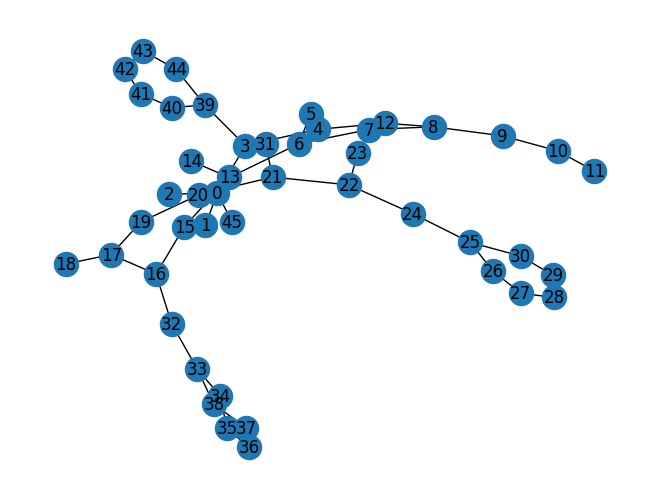

In [ ]:
G = edge_to_graph(dataset[13].edge_index)
nx.draw(G, with_labels = True)

## Rewire Data

In [11]:
def rewire(dataset, rewiring, k):
  N = len(dataset)
  dataset_new = []
  for i in tqdm(range(N)):
    data = dataset[i]
    G = nx.from_numpy_array(to_dense_adj(data.edge_index)[0].numpy())
    empty = False
    if G.number_of_edges() < 0.5:
      empty = True
    elif rewiring == "HHS":
      A, edge_to_index, L, D = create_views(G)
      G2 = rewire_hhs(copy.deepcopy(G),3,A,edge_to_index,L,D,True)
    elif rewiring == "sdrf":
      G2 = sdrf(copy.deepcopy(G),loops=k)
    else:
      G2 = fosr(copy.deepcopy(G),r=50, k=k)

    if not empty:
      data.rewired_edge_index = torch.tensor(nx.adjacency_matrix(G2).toarray()).to(torch.float).nonzero().t().contiguous()
    else:
      data.rewired_edge_index = data.edge_index

    dataset_new.append(data)
  return dataset_new

def merge_datasets(data_x, data_edge):
  dataset_new = []
  N = len(data_x)
  for i in tqdm(range(N)):
    data = data_x[i]
    data.rewired_edge_index = data_edge[i].rewired_edge_index
    dataset_new.append(data)
  return dataset_new

class RewiredDataset(InMemoryDataset):
  def __init__(self, dataset, rewiring, k, merge = False, data_edge = None):
    super(RewiredDataset, self).__init__('.', None, None, None)
    if merge:
      self.dataset_rewired = merge_datasets(dataset, data_edge)
    else:
      self.dataset_rewired = rewire(dataset, rewiring, k)

  def get(self, idx):
    return self.dataset_rewired[idx]

  def len(self):
    return len(self.dataset_rewired)

  def _download(self):
    return

  def _process(self):
      return

  def __repr__(self):
      return '{}()'.format(self.__class__.__name__)

In [ ]:
with open('/content/drive/MyDrive/CubeRep-Rewiring/data/protein-rewired.pkl', 'rb') as fp:
  adjacencies = pickle.load(fp)

In [ ]:
dataset_rewired = []
for i in range(len(adjacencies)):
  A = torch.tensor(np.array(adjacencies[i]))
  data = Data()
  data.rewired_edge_index = A.to(torch.float).nonzero().t().contiguous()
  dataset_rewired.append(data)

In [ ]:
hhs_dataset = RewiredDataset(dataset, "HHS", 3, merge = True, data_edge = dataset_rewired)

100%|██████████| 1113/1113 [00:00<00:00, 25795.63it/s]


In [ ]:
dataset_gtr = torch_geometric.datasets.GEDDataset(root="data_rewired/", name = "LINUX", transform = transform, pre_transform=pre_transform)
dataset = torch_geometric.datasets.GEDDataset(root="data/", name = "LINUX")

# dataset_gtr = torch_geometric.datasets.ZINC(root="data_rewired/", subset = True, split = "train", transform = transform, pre_transform=pre_transform)
# dataset = torch_geometric.datasets.ZINC(root="data/", subset = True, split = "train")

Extracting data_rewired/raw/uc
Processing...
Done!
Extracting data/raw/uc
Processing...
Done!


In [ ]:
hhs_dataset = RewiredDataset(dataset, "HHS", 3)
torch.save(hhs_dataset, "/content/drive/MyDrive/CubeRep-Rewiring/data/LINUX-hhs.pt")
hhs_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/LINUX-hhs.pt")

100%|██████████| 800/800 [00:12<00:00, 64.40it/s]


In [ ]:
fosr_dataset = RewiredDataset(dataset, "fosr", 3)
torch.save(fosr_dataset, "/content/drive/MyDrive/CubeRep-Rewiring/data/LINUX-fosr.pt")
fosr_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/LINUX-fosr.pt")

100%|██████████| 800/800 [00:09<00:00, 88.28it/s]


In [ ]:
sdrf_dataset = RewiredDataset(dataset, "sdrf", 3)
torch.save(sdrf_dataset, "/content/drive/MyDrive/CubeRep-Rewiring/data/LINUX-sdrf.pt")
sdrf_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/LINUX-sdrf.pt")

  0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 800/800 [00:06<00:00, 119.54it/s]


In [ ]:
hhs_edge_index = []
fosr_edge_index = []
sdrf_edge_index = []
orig_edge_index = []

for i in range(1113):
  # hhs_edge_index.append(hhs_dataset[i].rewired_edge_index)
  # fosr_edge_index.append(fosr_dataset[i].rewired_edge_index)
  # sdrf_edge_index.append(sdrf_dataset[i].rewired_edge_index)
  orig_edge_index.append(hhs_dataset[i].edge_index.detach())

path = "/content/drive/MyDrive/CubeRep-Rewiring/data/"

# with open(path+"hhs_edge_index.pkl", "wb") as f:
#         pickle.dump(hhs_edge_index,f,protocol=pickle.HIGHEST_PROTOCOL)
# with open(path+"fosr_edge_index.pkl", "wb") as f:
#         pickle.dump(fosr_edge_index,f,protocol=pickle.HIGHEST_PROTOCOL)
# with open(path+"sdrf_edge_index.pkl", "wb") as f:
#         pickle.dump(sdrf_edge_index,f,protocol=pickle.HIGHEST_PROTOCOL)
with open(path+"orig_edge_index-3.pkl", "wb") as f:
        pickle.dump(orig_edge_index,f,protocol=pickle.HIGHEST_PROTOCOL)

IndexError: ignored

In [ ]:
for i in range(1113):
  print(orig_edge_index[i].shape[0] - hhs_edge_index[i].shape[0])

In [ ]:
hhs_edge_index[0]

### Compute Statistics

In [ ]:
eigen_gap = torch.zeros(5,len(hhs_dataset))
average_commute_times = torch.zeros(5,len(hhs_dataset))
average_curvature = torch.zeros(5,len(hhs_dataset))
bottleneck_distance = torch.zeros(4,len(hhs_dataset))

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in tqdm(range(len(hhs_dataset))):
  G_orig = edge_to_graph(dataset[i].edge_index)
  G_hhs = edge_to_graph(hhs_dataset[i].rewired_edge_index)
  G_sdrf = edge_to_graph(sdrf_dataset[i].rewired_edge_index)
  G_fosr = edge_to_graph(fosr_dataset[i].rewired_edge_index)
  G_gtr = edge_to_graph(dataset_gtr[i].edge_index)

  # print(G_orig.number_of_nodes(), G_hhs.number_of_nodes())

  if G_orig.number_of_edges() > 0:

    try:
      eigen_gap[0,i] = calc_eigengap(G_orig)
    except:
      print(calc_eigengap(G_orig))
    try:
      eigen_gap[1,i] = calc_eigengap(G_hhs)
    except:
      print(calc_eigengap(G_hhs))
    try:
      eigen_gap[2,i] = calc_eigengap(G_sdrf)
    except:
      print(calc_eigengap(G_sdrf))
    try:
      eigen_gap[3,i] = calc_eigengap(G_fosr)
    except:
      print(calc_eigengap(G_fosr))
    try:
      eigen_gap[4,i] = calc_eigengap(G_gtr)
    except:
      print(calc_eigengap(G_gtr))

    average_commute_times[0,i] = calc_average_commute(G_orig)
    average_commute_times[1,i] = calc_average_commute(G_hhs)
    average_commute_times[2,i] = calc_average_commute(G_sdrf)
    average_commute_times[3,i] = calc_average_commute(G_fosr)
    average_commute_times[4,i] = calc_average_commute(G_gtr)

    average_curvature[0,i] = calc_average_curvature(G_orig)
    average_curvature[1,i] = calc_average_curvature(G_hhs)
    average_curvature[2,i] = calc_average_curvature(G_sdrf)
    average_curvature[3,i] = calc_average_curvature(G_fosr)
    average_curvature[4,i] = calc_average_curvature(G_gtr)

    # print(G_orig.number_of_nodes(), G_hhs.number_of_nodes(), G_sdrf.number_of_nodes(), G_fosr.number_of_nodes())

    Ds = graphs_to_dists([G_orig,G_hhs,G_sdrf,G_fosr,G_gtr])
    dgms = compute_homologies(Ds, 3, sparse = False)
    dists = homology_distance(dgms, metric = "betti")

    bottleneck_distance[0,i] = dists[0,1] #calc_bottleneck_distance(G_orig, G_hhs)
    bottleneck_distance[1,i] = dists[0,2] #calc_bottleneck_distance(G_orig, G_sdrf)
    bottleneck_distance[2,i] = dists[0,3] #calc_bottleneck_distance(G_orig, G_fosr)
    bottleneck_distance[3,i] = dists[0,4] #calc_bottleneck_distance(G_orig, G_gtr)

 14%|█▍        | 113/800 [00:07<01:05, 10.54it/s]

(0.5-2.2511892427057772e-17j)


100%|██████████| 800/800 [00:44<00:00, 18.02it/s]


In [ ]:
i = 1
G_orig = edge_to_graph(dataset[i].edge_index)
G_fosr = edge_to_graph(sdrf_dataset[i].rewired_edge_index)
print(G_orig.number_of_edges(), G_fosr.number_of_edges())

4 5


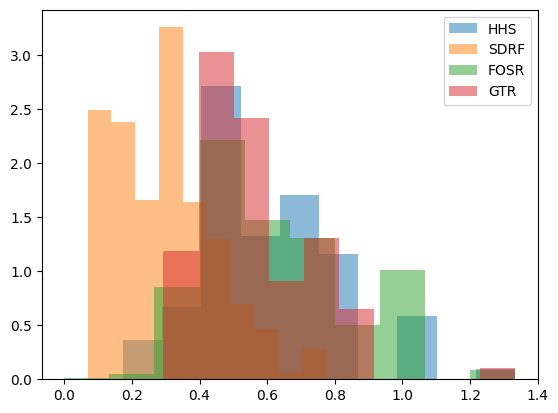

In [ ]:
# plt.hist(eigen_gap[0,:], alpha = 0.5, label = "Original", density = True)
plt.hist(eigen_gap[1,:], alpha = 0.5, label = "HHS", density = True)
plt.hist(eigen_gap[2,:], alpha = 0.5, label = "SDRF", density = True)
plt.hist(eigen_gap[3,:], alpha = 0.5, label = "FOSR", density = True)
plt.hist(eigen_gap[4,:], alpha = 0.5, label = "GTR", density = True)
plt.legend()

In [ ]:
for i in range(5):
  print((eigen_gap[i,:]).mean())

tensor(0.2040)
tensor(0.6039)
tensor(0.2974)
tensor(0.6176)
tensor(0.5687)


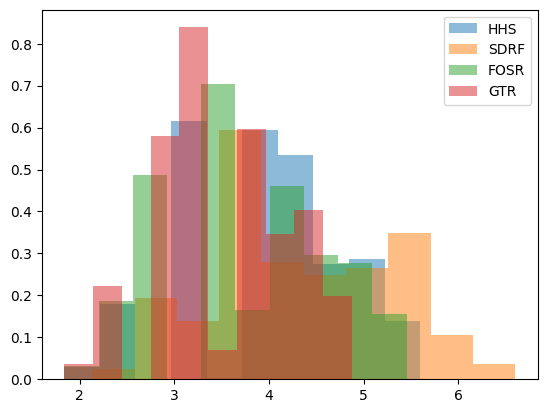

In [ ]:
# plt.hist(average_commute_times[0,:], alpha = 0.5, label = "Original", density = True)
plt.hist(average_commute_times[1,:], alpha = 0.5, label = "HHS", density = True)
plt.hist(average_commute_times[2,:], alpha = 0.5, label = "SDRF", density = True)
plt.hist(average_commute_times[3,:], alpha = 0.5, label = "FOSR", density = True)
plt.hist(average_commute_times[4,:], alpha = 0.5, label = "GTR", density = True)
plt.legend()

In [ ]:
for i in range(1,5):
  print((average_commute_times[i,:]).mean())

tensor(3.9244)
tensor(4.3083)
tensor(3.7748)
tensor(3.5581)


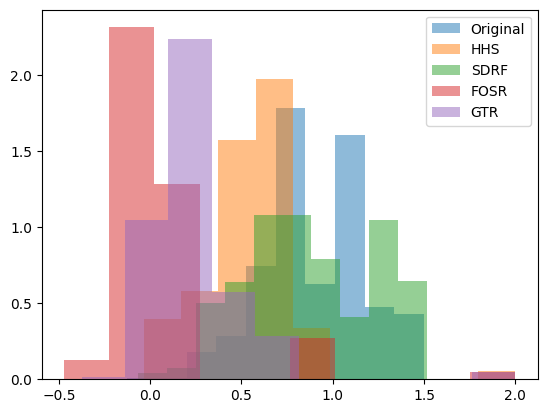

In [ ]:
plt.hist(average_curvature[0,:], alpha = 0.5, label = "Original", density = True)
plt.hist(average_curvature[1,:], alpha = 0.5, label = "HHS", density = True)
plt.hist(average_curvature[2,:], alpha = 0.5, label = "SDRF", density = True)
plt.hist(average_curvature[3,:], alpha = 0.5, label = "FOSR", density = True)
plt.hist(average_curvature[4,:], alpha = 0.5, label = "GTR", density = True)
plt.legend()

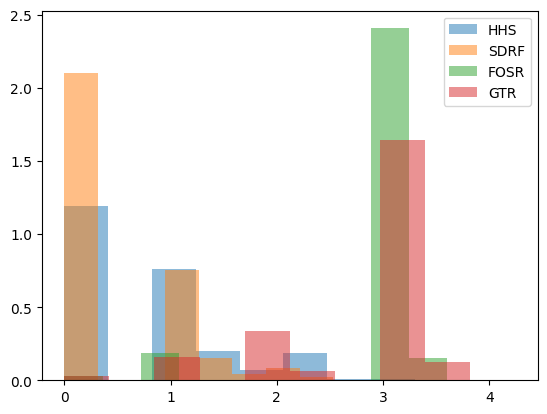

In [ ]:
# plt.hist(bottleneck_distance[0,:], alpha = 0.5, label = "Original", density = True)
plt.hist(bottleneck_distance[0,:], alpha = 0.5, label = "HHS", density = True)
plt.hist(bottleneck_distance[1,:], alpha = 0.5, label = "SDRF", density = True)
plt.hist(bottleneck_distance[2,:], alpha = 0.5, label = "FOSR", density = True)
plt.hist(bottleneck_distance[3,:], alpha = 0.5, label = "GTR", density = True)
plt.legend()

In [ ]:
for i in range(4):
  print((bottleneck_distance[i,:]).mean())

tensor(0.6858)
tensor(0.4037)
tensor(2.8829)
tensor(2.7376)


In [ ]:
relwire = torch.tensor([[1/1.1,2.5**2], [1/0.094, 2.7**2], [1/0.048, 3.5**2], [1/0.083, 3.1**2], [1/0.24,2.2**2], [1/0.4, 1.7**2], [1/0.19, 2.2**2],
                        [1/0.46, 0.43**2], [1/0.46, 1**2], [1/0.6, 0.68**2]])
relwire.square().sum()

tensor(1147.8005)

In [ ]:
gtr = torch.tensor([[1/1.3,4.6**2], [1/0.13,5.2**2], [1/0.08,5.9**2], [1/0.12,5.3**2], [1/0.26,4.3**2], [1/0.4,3.5**2], [1/0.23,4.2**2],
                    [1/0.43,3**2], [1/0.49,3**2], [1/0.37,2.7**2]])
gtr.square().sum()

tensor(4540.2300)

In [ ]:
fosr = torch.tensor([[1/1.1,3.5**2],[1/0.065,3.5**2],[1/0.033,3.8**2],[1/0.056,3.7**2],[1/0.22,3.2**2],[1/0.37,3**2],[1/0.15,3.2**2],
                     [1/0.47,2.9**2],[1/0.44,2.9**2],[1/0.62,2.9**2]])
fosr.square().sum()

tensor(2758.3220)

In [ ]:
sdrf = torch.tensor([[1/0.06,1.2**2],[1/0.029,0.86**2],[1/0.017,1**2],[1/0.03,1**2],[1/0.12,0.7**2],[1/0.21,0.7**2],
                     [1/0.1,1.3**2],[1/0.24,0.41**2],[1/0.31,0.65**2],[1/0.3,0.4**2]])
sdrf.square().sum()

tensor(6277.3442)

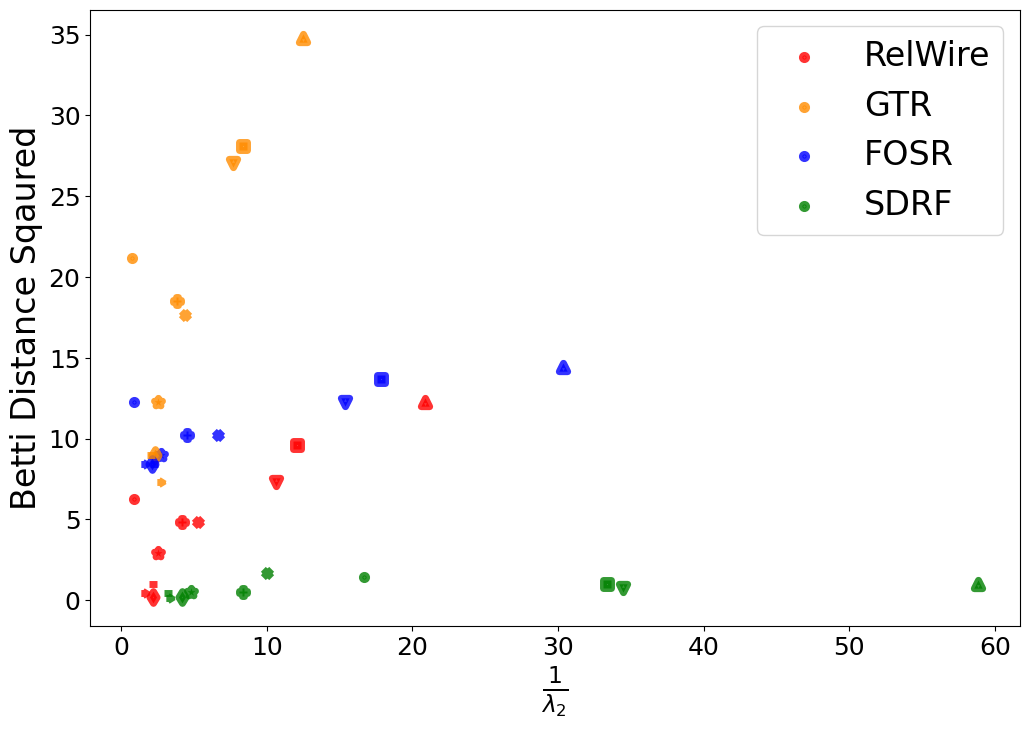

In [ ]:
fig,_ = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

shapes = [".", "v", "^", "s", "P", "*", "x", "d", "_", "3"]

for i in range(10):
  plt.scatter(relwire[i,0], relwire[i,1], color = "red", marker = shapes[i], alpha = 0.8, linewidth = 5)
  plt.scatter(gtr[i,0], gtr[i,1], color = "darkorange", marker = shapes[i], alpha = 0.8, linewidth = 5)
  plt.scatter(fosr[i,0], fosr[i,1], color = "blue", marker = shapes[i], alpha = 0.8, linewidth = 5)
  plt.scatter(sdrf[i,0], sdrf[i,1], color = "green", marker = shapes[i], alpha = 0.8, linewidth = 5)
plt.xlabel(r"$\frac{1}{\lambda_2}$", fontsize = 24)
plt.ylabel("Betti Distance", fontsize = 24)
plt.legend(["RelWire", "GTR", "FOSR", "SDRF"], fontsize = 24)
plt.savefig("eigengap-betti.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

# Create Synthetic Datasets

In [ ]:
 def create_synthetic_dataset(N,barbell_mean_size,bridge_mean_size,pm=3,regression = False,d=128,bridge_node = True):
  dataset = []
  for barbell in range(barbell_mean_size-pm,barbell_mean_size+pm+1):
    for bridge in range(bridge_mean_size-pm,bridge_mean_size+pm+1):
      for k in range(N):
        num_nodes = bridge + 2*barbell
        G = nx.empty_graph(num_nodes)
        pi = np.random.permutation(num_nodes)
        # pi = range(num_nodes)
        for i in range(barbell):
          for j in range(i):
            G.add_edge(pi[i],pi[j]) # First barbell
            G.add_edge(pi[-(i+1)],pi[-(j+1)]) # second barbell

        for i in range(bridge+1):
          G.add_edge(pi[i+barbell-1], pi[i+barbell])

        if bridge_node:
          u = pi[barbell-1]
          v = pi[-barbell]
        else:
          u = pi[np.random.randint(barbell-1)]
          v = pi[-np.random.randint(barbell-1)-1]

        if not regression:
          x = torch.round(torch.rand(num_nodes,1))

          if x[u] == x[-(v)]:
            y = 1
          else:
            y = 0
        else:
          x = torch.randn(num_nodes,d)
          y = (x[u] * x[v]).sum()


        edge_index = graph_to_edge(G)
        data = Data(x=x,edge_index = edge_index,y=y)
        dataset.append(data)
  return dataset

In [ ]:
synth_dataset = create_synthetic_dataset(250,6,6, bridge_node = True, regression = True)
print(len(synth_dataset))
G = edge_to_graph(synth_dataset[2056].edge_index)
nx.draw(G, with_labels = True)
print(synth_dataset[2056].y, synth_dataset[2056].x)

In [ ]:
torch.save(create_synthetic_dataset(250,6,6,regression = True),"/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression.pt")
# torch.save(create_synthetic_dataset(250,6,6),"/content/drive/MyDrive/CubeRep-Rewiring/data/synth-classification.pt")

# Rewire Sythnetic Datasets

In [ ]:
dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression.pt")

In [ ]:
for k in [1,3,5,7,9]:
  # hhs_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-class-hhs-"+str(k)+".pt")
  # hhs_dataset_reg = RewiredDataset(dataset, "HHS", k, merge = False)
  # torch.save(hhs_dataset_reg, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-hhs-"+str(k)+".pt")

  # fosr_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-class-fosr-"+str(k)+".pt")
  fosr_dataset_reg = RewiredDataset(dataset, "fosr", k, merge= False)
  torch.save(fosr_dataset_reg, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-fosr-"+str(k)+".pt")

  # sdrf_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-class-sdrf-"+str(k)+".pt")
  sdrf_dataset_reg = RewiredDataset(dataset, "sdrf", k, merge = False)
  torch.save(sdrf_dataset_reg, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-sdrf-"+str(k)+".pt")


In [12]:
class RewiredDatasetEdgeIndex(InMemoryDataset):
  def __init__(self, dataset, index = None):
    super(RewiredDatasetEdgeIndex, self).__init__('.', None, None, None)

    self.dataset_rewired = []
    if index == None:
      for i in range(len(dataset)):
        data = dataset[i]
        self.dataset_rewired.append(Data(x = data.x, edge_index = data.rewired_edge_index, y = data.y))
    else:
      for i in range(len(index)):
        self.dataset_rewired.append(dataset[index[i]])

  def get(self, idx):
    return self.dataset_rewired[idx]

  def len(self):
    return len(self.dataset_rewired)

  def _download(self):
    return

  def _process(self):
      return

  def __repr__(self):
      return '{}()'.format(self.__class__.__name__)

In [ ]:
for k in [1,3,5,7,9]:
  hhs_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-hhs-"+str(k)+".pt")
  hhs_train = RewiredDatasetEdgeIndex(hhs_dataset[graph_class_split[:num_train]])
  hhs_val = RewiredDatasetEdgeIndex(hhs_dataset[graph_class_split[num_train:num_train+num_val]])
  hhs_test = RewiredDatasetEdgeIndex(hhs_dataset[graph_class_split[-num_test:]])
  torch.save(hhs_train, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-hhs-train-"+str(k)+".pt")
  torch.save(hhs_val, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-hhs-val-"+str(k)+".pt")
  torch.save(hhs_test, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-hhs-test-"+str(k)+".pt")

  sdrf_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-sdrf-"+str(k)+".pt")
  sdrf_train = RewiredDatasetEdgeIndex(sdrf_dataset[graph_class_split[:num_train]])
  sdrf_val = RewiredDatasetEdgeIndex(sdrf_dataset[graph_class_split[num_train:num_train+num_val]])
  sdrf_test = RewiredDatasetEdgeIndex(sdrf_dataset[graph_class_split[-num_test:]])
  torch.save(sdrf_train, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-sdrf-train-"+str(k)+".pt")
  torch.save(sdrf_val, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-sdrf-val-"+str(k)+".pt")
  torch.save(sdrf_test, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-sdrf-test-"+str(k)+".pt")


  fosr_dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-fosr-"+str(k)+".pt")
  fosr_train = RewiredDatasetEdgeIndex(fosr_dataset[graph_class_split[:num_train]])
  fosr_val = RewiredDatasetEdgeIndex(fosr_dataset[graph_class_split[num_train:num_train+num_val]])
  fosr_test = RewiredDatasetEdgeIndex(fosr_dataset[graph_class_split[-num_test:]])
  torch.save(fosr_train, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-fosr-train-"+str(k)+".pt")
  torch.save(fosr_val, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-fosr-val-"+str(k)+".pt")
  torch.save(fosr_test, "/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-fosr-test-"+str(k)+".pt")


In [ ]:
train_data = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-train.pt")
val_data = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-val.pt")
test_data = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-regression-test.pt")

In [ ]:
test_data.len()

# Train Networks

In [13]:
class GNN(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, num_layers, hidden_dim = 128, device = "cuda"):
    super().__init__()

    self.num_layers = num_layers
    self.layers = []
    self.layers.append(torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim).to(device))
    for i in range(num_layers-1):
      self.layers.append(torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim).to(device))

    self.layers = torch.nn.ModuleList(self.layers)

    self.lin = torch.nn.Linear(hidden_dim, num_classes).to(device)

  def forward(self, x, edge_index, batch):
    for i in range(self.num_layers):
      x = self.layers[i](x, edge_index).relu()

    x = torch_geometric.nn.global_mean_pool(x, batch).relu()
    z = self.lin(x)
    return z

In [14]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
from tqdm import tqdm


# model = HHSConvNode(1703,5,128, hidden_dim = 128)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay = 0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)

path = "./drive/MyDrive/CubeRep-Rewiring/Models/Synth/Class/"

def train(model, train_loader, val_loader, test_loader, filename, iterations = 1000, criterion = torch.nn.MSELoss()):
  model.train()

  optimizer = torch.optim.Adam(model.parameters())
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

  for i in tqdm(range(iterations)):
    model.train()
    for data in train_loader:
      optimizer.zero_grad()  # Clear gradients.
      data = data.to('cuda')
      out = model(data.x.float(), data.rewired_edge_index, data.batch)  # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
    with torch.no_grad():
      torch.save(model,filename+str(i)+".pt")
    scheduler.step()
    if i % 100 == 0:
      with torch.no_grad():
        print("Trianing Error", loss)
        print("Train MSE", test_mse(train_loader, model))
        print("Val MSE", test_mse(val_loader, model))
        print("Test MSE", test_mse(test_loader, model))


  return model

def train_orig(model, train_loader, val_loader, test_loader, filename, iterations = 1000, criterion = torch.nn.MSELoss()):
  model.train()

  optimizer = torch.optim.Adam(model.parameters())
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

  for i in tqdm(range(iterations)):
    model.train()
    for data in train_loader:
      optimizer.zero_grad()  # Clear gradients.
      data = data.to('cuda')
      out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
    with torch.no_grad():
      torch.save(model,filename+str(i)+".pt")
    scheduler.step()
    if i % 100 == 0:
      with torch.no_grad():
        print("Trianing Error", loss)
        print("Train MSE", test_mse_orig(train_loader, model))
        print("Val MSE", test_mse_orig(val_loader, model))
        print("Test MSE", test_mse_orig(test_loader, model))


  return model

def test(loader, edge_loader = None):
  model.eval()

  correct = 0
  for data in loader:
    data = data.to('cuda')
    out = model(data.x.float(), data.rewired_edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct += (pred == data.y).sum()
  return correct / (len(loader)*data.y.shape[0]) # Derive ratio of correct predictions.

def test_orig(loader, edge_loader = None):
  model.eval()

  correct = 0
  for data in loader:
    data = data.to('cuda')
    out = model(data.x.float(), data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    correct += (pred == data.y).sum()
  return correct / (len(loader)*data.y.shape[0]) # Derive ratio of correct predictions.

def test_mse(loader, edge_loader = None):
  model.eval()

  correct = 0
  for data in loader:
    data = data.to('cuda')
    out = model(data.x.float(), data.rewired_edge_index, data.batch)
    correct += (out-data.y).square().sum().detach().cpu()
  return correct / (len(loader)*data.y.shape[0]) # Derive ratio of correct predictions.

def test_mse_orig(loader, edge_loader = None):
  model.eval()

  correct = 0
  for data in loader:
    data = data.to('cuda')
    out = model(data.x.float(), data.edge_index, data.batch)
    correct += (out-data.y).square().sum().detach().cpu()
  return correct / (len(loader)*data.y.shape[0]) # Derive ratio of correct predictions.

<IPython.core.display.Javascript object>

In [92]:
graph_class_split = torch.randperm(600)
num_train = 500
num_val = 50
num_test = 50
torch.save(graph_class_split, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-split.pt")
# graph_class_split = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/synth-split.pt")

In [18]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 57.4 MB/s eta 0:00:00


In [93]:
import torch_geometric.transforms as T
pre_transform = T.Compose([PrecomputeGTREdges(num_edges=3)])
transform = T.Compose([AddPrecomputedGTREdges(num_edges=3)])

dataset_gtr = torch_geometric.datasets.TUDataset(root="data_rewired/",name = "ENZYMES", transform = transform, pre_transform=pre_transform)
train_data = RewiredDatasetEdgeIndex(dataset_gtr, graph_class_split[:num_train])
val_data = RewiredDatasetEdgeIndex(dataset_gtr, graph_class_split[num_train:num_train+num_val])
test_data = RewiredDatasetEdgeIndex(dataset_gtr, graph_class_split[-num_test:])
torch.save(train_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-gtr-train.pt")
torch.save(val_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-gtr-val.pt")
torch.save(test_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-gtr-test.pt")

dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-hhs.pt")
print(len(dataset))
train_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[:num_train])
val_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[num_train:num_train+num_val])
test_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[-num_test:])
torch.save(train_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-hhs-train.pt")
torch.save(val_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-hhs-val.pt")
torch.save(test_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-hhs-test.pt")

dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-sdrf.pt")
train_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[:num_train])
val_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[num_train:num_train+num_val])
test_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[-num_test:])
torch.save(train_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-sdrf-train.pt")
torch.save(val_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-sdrf-val.pt")
torch.save(test_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-sdrf-test.pt")

dataset = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-fosr.pt")
train_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[:num_train])
val_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[num_train:num_train+num_val])
test_data = RewiredDatasetEdgeIndex(dataset, graph_class_split[-num_test:])
torch.save(train_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/ENZYMES-fosr-train.pt")
torch.save(val_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/Tox21-fosr-val.pt")
torch.save(test_data, "/content/drive/MyDrive/CubeRep-Rewiring/data/Tox21-fosr-test.pt")

Extracting data_rewired/ENZYMES/ENZYMES.zip
Processing...
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
Done!


600


In [27]:
train_data_fosr = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-fosr-train.pt")
val_data_fosr = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-fosr-val.pt")
test_data_fosr = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-fosr-test.pt")

train_data_sdrf = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-sdrf-train.pt")
val_data_sdrf = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-sdrf-val.pt")
test_data_sdrf = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-sdrf-test.pt")

train_data_hhs = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-hhs-train.pt")
val_data_hhs = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-hhs-val.pt")
test_data_hhs = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-hhs-test.pt")

train_data_gtr = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-gtr-train.pt")
val_data_gtr = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-gtr-val.pt")
test_data_gtr = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/data/zinc-gtr-test.pt")

In [28]:
T = 5

train_errors = torch.zeros(5,T)
val_errors = torch.zeros(5,T)
test_errors = torch.zeros(5,T)

layers = [2]

for l in layers:
  for t in range(T):
    train_loader = DataLoader(train_data_sdrf, batch_size=800, shuffle=False)
    val_loader = DataLoader(val_data_sdrf, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_sdrf, batch_size=50, shuffle=False)

    model = GNN(1,1,l,hidden_dim = 256).to("cuda")
    model = train_orig(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Zinc/orig-trial-"+str(t)+"-epoch-", iterations = 100)
    train_errors[0,t] = test_mse_orig(train_loader, model)
    val_errors[0,t] = test_mse_orig(val_loader, model)
    test_errors[0,t] = test_mse_orig(test_loader, model)

    train_loader = DataLoader(train_data_hhs, batch_size=800, shuffle=False)
    val_loader = DataLoader(val_data_hhs, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_hhs, batch_size=50, shuffle=False)

    model = GNN(1,1,l,hidden_dim = 256).to("cuda")
    model = train(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Zinc/hhs-trial-"+str(t)+"-epoch-", iterations = 100)
    train_errors[1,t] = test_mse(train_loader, model)
    val_errors[1,t] = test_mse(val_loader, model)
    test_errors[1,t] = test_mse(test_loader, model)

    train_loader = DataLoader(train_data_sdrf, batch_size=800, shuffle=False)
    val_loader = DataLoader(val_data_sdrf, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_sdrf, batch_size=50, shuffle=False)

    model = GNN(1,1,l,hidden_dim = 256).to("cuda")
    model = train(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Zinc/sdrf-trial-"+str(t)+"-epoch-", iterations = 100)
    train_errors[2,t] = test_mse(train_loader, model)
    val_errors[2,t] = test_mse(val_loader, model)
    test_errors[2,t] = test_mse(test_loader, model)

    train_loader = DataLoader(train_data_fosr, batch_size=800, shuffle=False)
    val_loader = DataLoader(val_data_fosr, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_fosr, batch_size=50, shuffle=False)

    model = GNN(1,1,l,hidden_dim = 256).to("cuda")
    model = train(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Zinc/fosr-trial-"+str(t)+"-epoch-", iterations = 100)
    train_errors[3,t] = test_mse(train_loader, model)
    val_errors[3,t] = test_mse(val_loader, model)
    test_errors[3,t] = test_mse(test_loader, model)

    train_loader = DataLoader(train_data_gtr, batch_size=800, shuffle=False)
    val_loader = DataLoader(val_data_gtr, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_gtr, batch_size=50, shuffle=False)

    model = GNN(1,1,l,hidden_dim = 256).to("cuda")
    model = train_orig(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Zinc/gtr-trial-"+str(t)+"-epoch-", iterations = 100)
    train_errors[4,t] = test_mse_orig(train_loader, model)
    val_errors[4,t] = test_mse_orig(val_loader, model)
    test_errors[4,t] = test_mse_orig(test_loader, model)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([800])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Trianing Error tensor(3.9648, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3289.4275)
Val MSE tensor(200.5478)


  1%|          | 1/100 [00:04<07:38,  4.63s/it]

Test MSE tensor(186.0696)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0383, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3404.1326)
Val MSE tensor(208.1514)


  1%|          | 1/100 [00:01<02:36,  1.58s/it]

Test MSE tensor(193.7228)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9661, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3280.4846)
Val MSE tensor(199.6311)


  1%|          | 1/100 [00:01<02:48,  1.70s/it]

Test MSE tensor(185.5011)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9959, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3344.2571)
Val MSE tensor(203.0938)


  1%|          | 1/100 [00:01<02:35,  1.57s/it]

Test MSE tensor(189.5073)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9794, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3324.2183)
Val MSE tensor(202.9734)


  1%|          | 1/100 [00:01<02:23,  1.45s/it]

Test MSE tensor(188.3580)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0664, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3453.4131)
Val MSE tensor(211.4516)


  1%|          | 1/100 [00:01<02:34,  1.57s/it]

Test MSE tensor(196.5086)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0275, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3361.9338)
Val MSE tensor(204.0807)


  1%|          | 1/100 [00:01<02:38,  1.60s/it]

Test MSE tensor(190.5482)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9841, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3333.2520)
Val MSE tensor(203.6353)


  1%|          | 1/100 [00:01<02:35,  1.57s/it]

Test MSE tensor(188.8129)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0140, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3359.4475)
Val MSE tensor(205.3391)


  1%|          | 1/100 [00:01<02:38,  1.60s/it]

Test MSE tensor(190.5168)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0405, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3387.0356)
Val MSE tensor(207.0715)


  1%|          | 1/100 [00:01<02:28,  1.50s/it]

Test MSE tensor(192.4152)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0142, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3331.4473)
Val MSE tensor(202.3491)


  1%|          | 1/100 [00:01<02:36,  1.58s/it]

Test MSE tensor(188.6235)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0375, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3291.2266)
Val MSE tensor(200.6541)


  1%|          | 1/100 [00:01<02:30,  1.52s/it]

Test MSE tensor(186.1421)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0271, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3398.4600)
Val MSE tensor(206.1323)


  1%|          | 1/100 [00:01<02:30,  1.52s/it]

Test MSE tensor(192.9151)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9930, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3341.2146)
Val MSE tensor(202.9825)


  1%|          | 1/100 [00:01<02:35,  1.57s/it]

Test MSE tensor(189.2986)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0391, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3392.2134)
Val MSE tensor(205.7996)


  1%|          | 1/100 [00:01<02:28,  1.50s/it]

Test MSE tensor(192.4510)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0309, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3378.5330)
Val MSE tensor(206.5717)


  1%|          | 1/100 [00:01<02:43,  1.65s/it]

Test MSE tensor(191.8266)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9848, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3275.5034)
Val MSE tensor(199.4895)


  1%|          | 1/100 [00:01<02:38,  1.60s/it]

Test MSE tensor(185.1922)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9932, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3275.3379)
Val MSE tensor(199.4042)


  1%|          | 1/100 [00:01<02:32,  1.54s/it]

Test MSE tensor(185.1145)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9677, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3295.2495)
Val MSE tensor(200.9683)


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

Test MSE tensor(186.6133)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0280, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3381.6086)
Val MSE tensor(205.3546)


  1%|          | 1/100 [00:01<02:25,  1.47s/it]

Test MSE tensor(191.9477)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0613, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3395.9045)
Val MSE tensor(207.6689)


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

Test MSE tensor(193.0648)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9869, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3311.7646)
Val MSE tensor(201.1674)


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

Test MSE tensor(187.3374)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.0932, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3407.8884)
Val MSE tensor(208.5179)


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

Test MSE tensor(193.6846)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(3.9903, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3322.7046)
Val MSE tensor(201.7994)


  1%|          | 1/100 [00:01<02:33,  1.55s/it]

Test MSE tensor(188.0969)


  0%|          | 0/100 [00:00<?, ?it/s]

Trianing Error tensor(4.1114, device='cuda:0', grad_fn=<MseLossBackward0>)
Train MSE tensor(3454.0005)
Val MSE tensor(211.6072)


  1%|          | 1/100 [00:01<02:20,  1.42s/it]

Test MSE tensor(196.5331)


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [29]:
idxes = val_errors.argmin(dim=1)
print(idxes)
test_errors[[0,1,2,3,4], idxes]

tensor([2, 3, 0, 3, 0])


tensor([185.0917, 185.0888, 185.0907, 185.0913, 185.0902])

In [30]:
test_errors.mean(dim=1)

tensor([185.0896, 185.0883, 185.0903, 185.0910, 185.0899])

In [101]:
torch.save(train_errors, "/content/drive/MyDrive/CubeRep-Rewiring/Zinc-train-errors.pt")
torch.save(val_errors, "/content/drive/MyDrive/CubeRep-Rewiring/Zinc-val-errors.pt")
torch.save(test_errors, "/content/drive/MyDrive/CubeRep-Rewiring/Zinc-test-erros.pt")

In [21]:
train_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Lipo-train-errors.pt")
val_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Lipo-val-errors.pt")
test_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Lipo-test-erros.pt")
idxes = val_errors.argmin(dim=1)
# print(idxes)
print(test_errors[[0,1,2,3,4], idxes])
test_errors.mean(dim=1)

tensor([0.7067, 0.6662, 0.6325, 0.7543, 1.1388])


tensor([0.6957, 0.7168, 0.7251, 0.7521, 1.1620])

In [22]:
train_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Zinc-train-errors.pt")
val_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Zinc-val-errors.pt")
test_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Zinc-test-erros.pt")
idxes = val_errors.argmin(dim=1)
# print(idxes)
print(test_errors[[0,1,2,3,4], idxes])
test_errors.mean(dim=1)

tensor([0.7067, 0.6662, 0.6325, 0.7543, 0.6998])


tensor([0.6957, 0.7168, 0.7251, 0.7521, 0.7093])

In [23]:
train_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/BACE-train-errors.pt")
val_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/BACE-val-errors.pt")
test_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/BACE-test-erros.pt")
idxes = val_errors.argmin(dim=1)
# print(idxes)
print(test_errors[[0,1,2,3,4], idxes])
test_errors.mean(dim=1)

tensor([0.5142, 0.5556, 0.5724, 0.6284, 0.6174])


tensor([0.5504, 0.5968, 0.5788, 0.5886, 0.5742])

In [24]:
train_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/esol-train-errors.pt")
val_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/esol-val-errors.pt")
test_errors = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/esol-test-erros.pt")
idxes = val_errors.argmin(dim=1)
# print(idxes)
print(test_errors[[0,1,2,3,4], idxes])
test_errors.mean(dim=1)

tensor([0.8605, 0.7631, 1.4253, 0.6936, 0.6012])


tensor([0.8504, 0.7875, 1.2042, 0.7323, 0.6990])

In [ ]:
def model_cpu(model):
  model.lin = model.lin.cpu()
  for i in range(model.num_layers):
    model.layers[i] = model.layers[i].cpu()
  return model

In [ ]:
T = 4

train_errors = torch.zeros(4,T)
val_errors = torch.zeros(4,T)
test_errors = torch.zeros(4,T)

layers = [2]

for l in layers:
  for t in range(T):
    train_loader = DataLoader(train_data_hhs, batch_size=100, shuffle=False)
    val_loader = DataLoader(val_data_hhs, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_hhs, batch_size=50, shuffle=False)

    # model = GNN(9,1,l,hidden_dim = 256).to("cuda")
    # model = train_orig(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/orig-trial-"+str(t)+"-epoch-", iterations = 1000)
    model = model_cpu(torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/orig-trial-"+str(t)+"-epoch-999.pt").cpu())
    train_errors[0,t] = test_mse_orig(train_loader, model)
    val_errors[0,t] = test_mse_orig(val_loader, model)
    test_errors[0,t] = test_mse_orig(test_loader, model)

    train_loader = DataLoader(train_data_hhs, batch_size=100, shuffle=False)
    val_loader = DataLoader(val_data_hhs, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_hhs, batch_size=50, shuffle=False)

    # model = GNN(9,1,l,hidden_dim = 256).to("cuda")
    # model = train(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/hhs-trial-"+str(t)+"-epoch-", iterations = 1000)
    model = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/hhs-trial-"+str(t)+"-epoch-999.pt").cpu()
    model = model_cpu(model)
    train_errors[1,t] = test_mse(train_loader, model)
    val_errors[1,t] = test_mse(val_loader, model)
    test_errors[1,t] = test_mse(test_loader, model)

    train_loader = DataLoader(train_data_sdrf, batch_size=100, shuffle=False)
    val_loader = DataLoader(val_data_sdrf, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_sdrf, batch_size=50, shuffle=False)

    # model = GNN(9,1,l,hidden_dim = 256).to("cuda")
    # model = train(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/sdrf-trial-"+str(t)+"-epoch-", iterations = 1000)
    model = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/sdrf-trial-"+str(t)+"-epoch-999.pt").cpu()
    model = model_cpu(model)
    train_errors[2,t] = test_mse(train_loader, model)
    val_errors[2,t] = test_mse(val_loader, model)
    test_errors[2,t] = test_mse(test_loader, model)

    train_loader = DataLoader(train_data_fosr, batch_size=100, shuffle=False)
    val_loader = DataLoader(val_data_fosr, batch_size=50, shuffle=False)
    test_loader = DataLoader(test_data_fosr, batch_size=50, shuffle=False)

    # model = GNN(9,1,l,hidden_dim = 256).to("cuda")
    # model = train(model, train_loader, val_loader, test_loader, "/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/fosr-trial-"+str(t)+"-epoch-", iterations = 1000)
    model = torch.load("/content/drive/MyDrive/CubeRep-Rewiring/Models/Lipo/fosr-trial-"+str(t)+"-epoch-999.pt").cpu()
    model = model_cpu(model)
    train_errors[3,t] = test_mse(train_loader, model)
    val_errors[3,t] = test_mse(val_loader, model)
    test_errors[3,t] = test_mse(test_loader, model)

In [ ]:
print(train_errors[0,:].mean(),train_errors[1,:].mean(),train_errors[2,:].mean(),train_errors[3,:].mean())

In [ ]:
print(val_errors[0,:].mean(),val_errors[1,:].mean(),val_errors[2,:].mean(),val_errors[3,:].mean())

In [ ]:
print(test_errors[0,:].mean(),test_errors[1,:].mean(),test_errors[2,:].mean(),test_errors[3,:].mean())

In [ ]:
list(train_loader)[0]

In [ ]:
model

In [ ]:
train(model, train_loader, val_loader, test_loader, iterations = 1000)

In [ ]:
from torch_geometric.utils import to_dense_adj
idx = 8
adj_matrix = to_dense_adj(dataset[idx].edge_index)[0]
G = nx.from_numpy_array(adj_matrix.numpy())

dataset[idx].edge_index = torch.zeros(2,2)#torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float).nonzero().t().contiguous()

In [ ]:
dataset[idx].edge_index

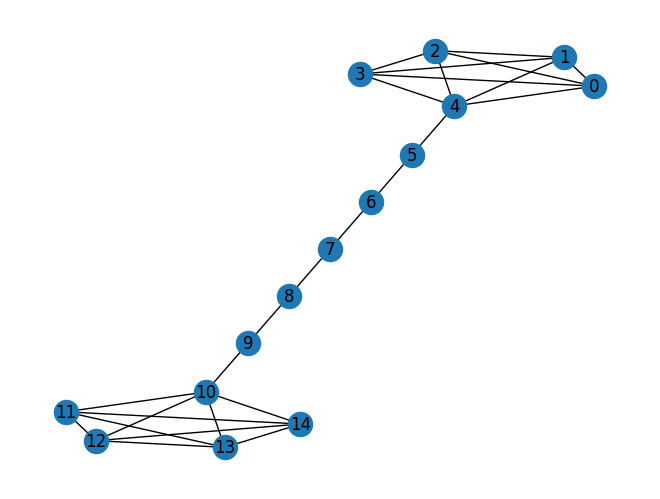

In [ ]:
# Lets create a example dumbell graph

G = nx.empty_graph(15)
for i in range(5):
  for j in range(i):
    G.add_edge(i,j)
    G.add_edge(i+10,j+10)

G.add_edge(4,5)
G.add_edge(5,6)
G.add_edge(6,7)
G.add_edge(7,8)
G.add_edge(8,9)
G.add_edge(9,10)

nx.draw_kamada_kawai(G, with_labels = True)

In [ ]:
barbell = Data(edge_index = graph_to_edge(G))

<ipython-input-10-fe53729df8cb>:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float).nonzero().t().contiguous()


In [ ]:
GTR_pre = PrecomputeGTREdges(num_edges=9)

In [ ]:
barbell_pre = GTR_pre(barbell)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [ ]:
barbells = [None,None,None,None,None,None,None,None,None]
for i in range(9):
  GTR = AddGTREdges(num_edges=i+1)
  barbells[i] = edge_to_graph(GTR(copy.deepcopy(barbell_pre)).edge_index)

We do not recommend using AddGTREdges. AddGTREdges computes additional edges each time a graph is loaded, which is computationally expensive. We recommend using PrecomputeGTREdges and AddPrecomputedGTREdges instead.
We do not recommend using AddGTREdges. AddGTREdges computes additional edges each time a graph is loaded, which is computationally expensive. We recommend using PrecomputeGTREdges and AddPrecomputedGTREdges instead.
We do not recommend using AddGTREdges. AddGTREdges computes additional edges each time a graph is loaded, which is computationally expensive. We recommend using PrecomputeGTREdges and AddPrecomputedGTREdges instead.
We do not recommend using AddGTREdges. AddGTREdges computes additional edges each time a graph is loaded, which is computationally expensive. We recommend using PrecomputeGTREdges and AddPrecomputedGTREdges instead.
We do not recommend using AddGTREdges. AddGTREdges computes additional edges each time a graph is loaded, which is computationally expen

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/storage.py:304: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_type', 'precomputed_gtr_edges', 'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


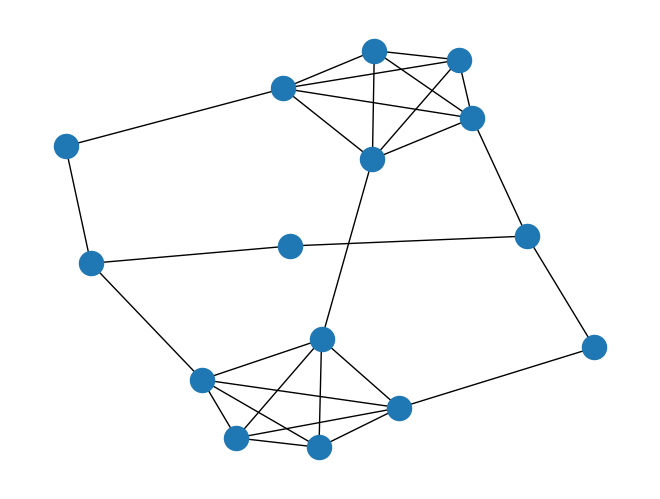

In [ ]:
nx.draw(barbells[2])

In [ ]:
Gs = [G1,G2,G3,G4,G5,G6,G7,G8,G9]

In [ ]:
Gs_fosr = [Ghat1, Ghat2, Ghat3, Ghat4, Ghat5, Ghat6, Ghat7, Ghat8, Ghat9]

In [15]:
def compute_rank(dgm):
  N = dgm.shape[0]
  rank = 0
  for i in range(N):
    if np.abs(dgm[i,0] - dgm[i,1]) > 0.5:
      rank += 1
  return rank

In [ ]:
Gs_hhs[0].shape

torch.Size([2, 576])

In [36]:
TL = len(Gs_hhs)

eigen_gap = torch.zeros(5,TL)
average_commute_times = torch.zeros(5,TL)
average_curvature = torch.zeros(5,TL)
bottleneck_distance = torch.zeros(4,TL)
ranks = torch.zeros(4,TL)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

G_orig = edge_to_graph(dataset.edge_index)
for i in tqdm(range(TL)):
  G_hhs = edge_to_graph(Gs_hhs[i])
  G_sdrf = edge_to_graph(Gs_sdrf[i])
  G_fosr = edge_to_graph(torch.tensor(Gs_fosr[i]))
  G_gtr = edge_to_graph(Gs_gtr[i])

  # print(G_orig.number_of_nodes(), G_hhs.number_of_nodes())

  if G_orig.number_of_edges() > 0:

    try:
      eigen_gap[0,i] = calc_eigengap(G_orig)
    except:
      print(calc_eigengap(G_orig))
    try:
      eigen_gap[1,i] = calc_eigengap(G_hhs)
    except:
      print(calc_eigengap(G_hhs))
    try:
      eigen_gap[2,i] = calc_eigengap(G_sdrf)
    except:
      print(calc_eigengap(G_sdrf))
    try:
      eigen_gap[3,i] = calc_eigengap(G_fosr)
    except:
      print(calc_eigengap(G_fosr))
    try:
      eigen_gap[4,i] = calc_eigengap(G_gtr)
    except:
      print(calc_eigengap(G_gtr))

    average_commute_times[0,i] = calc_average_commute(G_orig)
    average_commute_times[1,i] = calc_average_commute(G_hhs)
    average_commute_times[2,i] = calc_average_commute(G_sdrf)
    average_commute_times[3,i] = calc_average_commute(G_fosr)
    average_commute_times[4,i] = calc_average_commute(G_gtr)

    average_curvature[0,i] = calc_average_curvature(G_orig)
    average_curvature[1,i] = calc_average_curvature(G_hhs)
    average_curvature[2,i] = calc_average_curvature(G_sdrf)
    average_curvature[3,i] = calc_average_curvature(G_fosr)
    average_curvature[4,i] = calc_average_curvature(G_gtr)

    Ds = graphs_to_dists([G_orig,G_hhs,G_sdrf,G_fosr,G_gtr])
    dgms = compute_homologies(Ds, 1, sparse = True)

    ranks[0,i] = compute_rank(dgms[1])
    ranks[1,i] = compute_rank(dgms[2])
    ranks[2,i] = compute_rank(dgms[3])
    ranks[3,i] = compute_rank(dgms[4])

    # Ds = graphs_to_dists([G_orig,G_hhs,G_sdrf,G_fosr,G_gtr])
    # dgms = compute_homologies(Ds, 5, sparse = True)
    # dists = homology_distance(dgms, metric = "betti")

    # bottleneck_distance[0,i] = dists[0,1] #calc_bottleneck_distance(G_orig, G_hhs)
    # bottleneck_distance[1,i] = dists[0,2] #calc_bottleneck_distance(G_orig, G_sdrf)
    # bottleneck_distance[2,i] = dists[0,3] #calc_bottleneck_distance(G_orig, G_fosr)
    # bottleneck_distance[3,i] = dists[0,4] #calc_bottleneck_distance(G_orig, G_fosr)

100%|██████████| 100/100 [15:21<00:00,  9.22s/it]


In [ ]:
compute_rank(dgms[0])

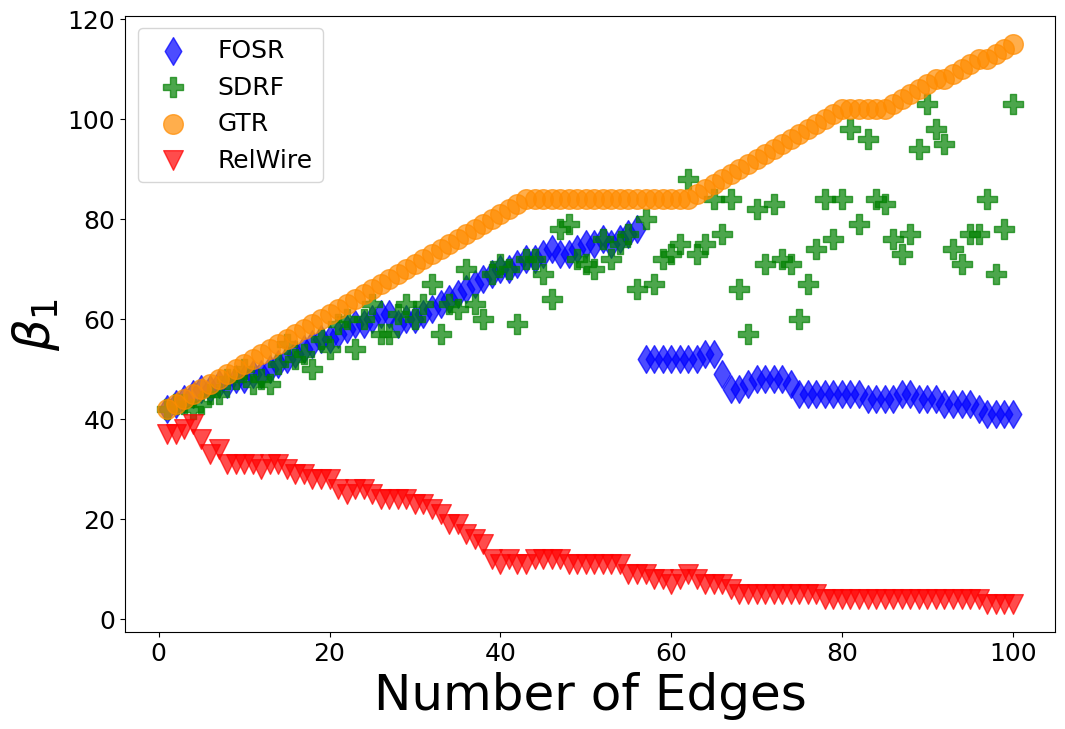

In [40]:
fig,ax = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.ylabel(r"$\beta_1$", fontsize = 36)
plt.xlabel(r"Number of Edges", fontsize = 36)

plt.scatter(range(1,TL+1), ranks[3-1,:], color = "Blue", label = "FOSR", s = 200, alpha = 0.7, marker = "d")
plt.scatter(range(1,TL+1), ranks[2-1,:], color = "Green", label = "SDRF", s = 200, alpha = 0.7, marker = "P")
plt.scatter(range(1,TL+1), ranks[4-1,:], color = "darkorange", label = "GTR", s = 200, alpha = 0.7)
plt.scatter(range(1,TL+1), ranks[1-1,:], color = "Red", label = "RelWire", s = 200, alpha = 0.7, marker = "v")

plt.legend(fontsize=18)
plt.savefig("cornell-ranks-h1.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

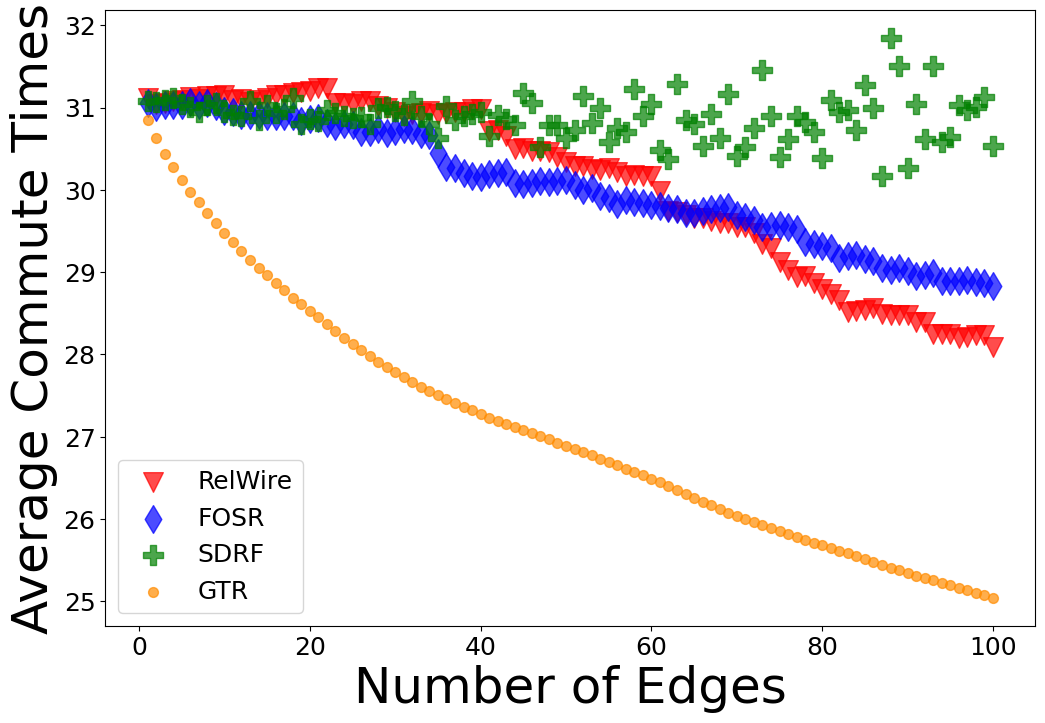

In [41]:
fig,ax = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.ylabel(r"Average Commute Times", fontsize = 36)
plt.xlabel(r"Number of Edges", fontsize = 36)

plt.scatter(range(1,TL+1), average_commute_times[1,:], color = "Red", label = "RelWire", s = 200, alpha = 0.7, marker = "v")
plt.scatter(range(1,TL+1), average_commute_times[3,:], color = "Blue", label = "FOSR", s = 200, alpha = 0.7, marker = "d")
plt.scatter(range(1,TL+1), average_commute_times[2,:], color = "Green", label = "SDRF", s = 200, alpha = 0.7, marker = "P")
plt.scatter(range(1,TL+1), average_commute_times[4,:], color = "darkorange", label = "GTR", s = 200, alpha = 0.7, marker = ".")

plt.legend(fontsize=18)
plt.savefig("cornell-commute-times.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

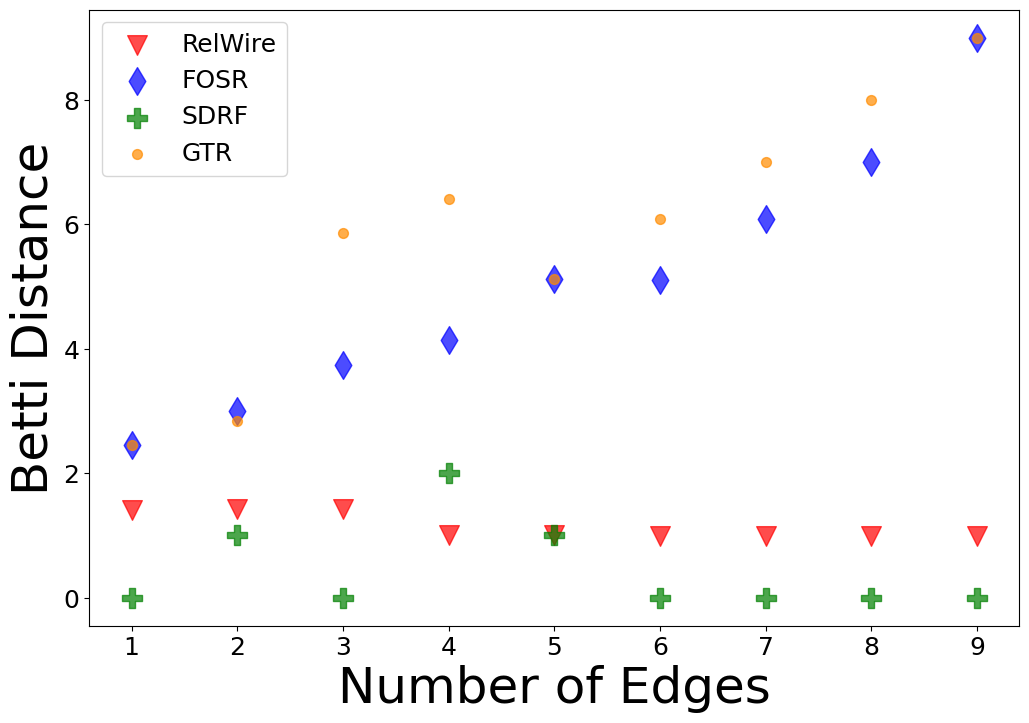

In [ ]:
fig,ax = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.ylabel(r"Betti Distance", fontsize = 36)
plt.xlabel(r"Number of Edges", fontsize = 36)


plt.scatter(range(1,10), bottleneck_distance[1-1,:], color = "Red", label = "RelWire", s = 200, alpha = 0.7, marker = "v")
plt.scatter(range(1,10), bottleneck_distance[3-1,:], color = "Blue", label = "FOSR", s = 200, alpha = 0.7, marker = "d")
plt.scatter(range(1,10), bottleneck_distance[2-1,:], color = "Green", label = "SDRF", s = 200, alpha = 0.7, marker = "P")
plt.scatter(range(1,10), bottleneck_distance[4-1,:], color = "darkorange", label = "GTR", s = 200, alpha = 0.7, marker = ".")

plt.legend(fontsize=18)
plt.savefig("cornell-betti.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

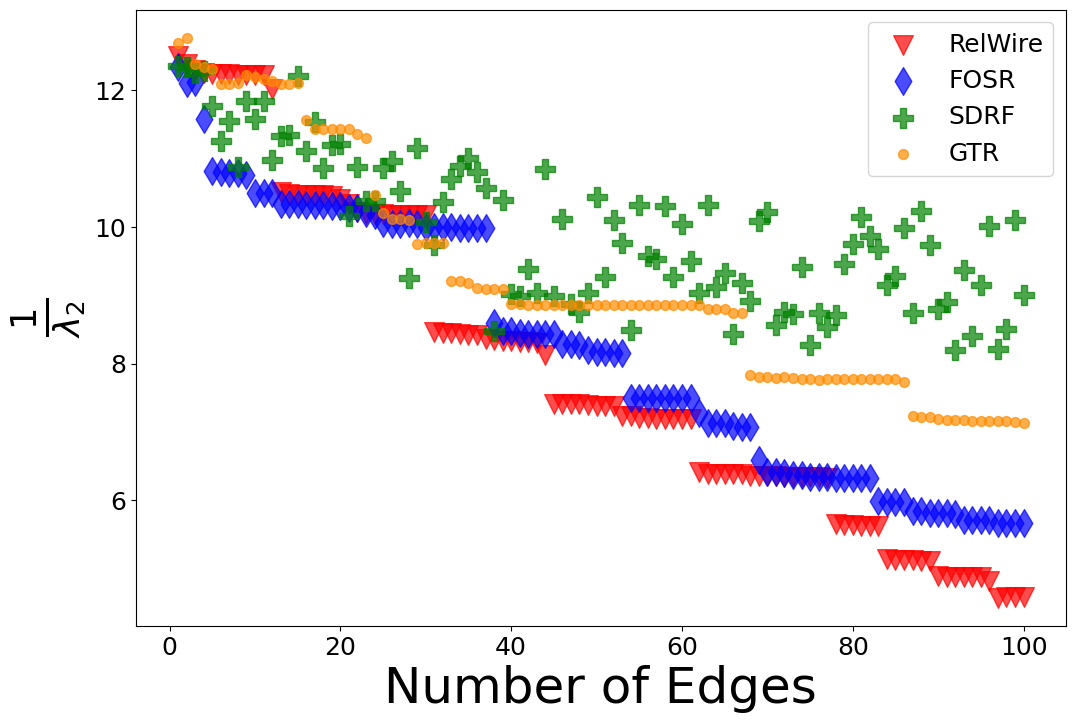

In [42]:
fig,ax = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.ylabel(r"$\frac{1}{\lambda_2}$", fontsize = 36)
plt.xlabel(r"Number of Edges", fontsize = 36)


plt.scatter(range(1,TL+1), 1/eigen_gap[1,:], color = "Red", label = "RelWire", s = 200, alpha = 0.7, marker = "v")
plt.scatter(range(1,TL+1), 1/eigen_gap[3,:], color = "Blue", label = "FOSR", s = 200, alpha = 0.7, marker = "d")
plt.scatter(range(1,TL+1), 1/eigen_gap[2,:], color = "Green", label = "SDRF", s = 200, alpha = 0.7, marker = "P")
plt.scatter(range(1,TL+1), 1/eigen_gap[4,:], color = "darkorange", label = "GTR", s = 200, alpha = 0.7, marker = ".")

plt.legend(fontsize=18)
plt.savefig("cornell-eigengap.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
!sudo apt install graphviz-dev -y
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 16 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 [2,037 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgail18 amd64 2.24.33-2ubuntu2 [15.9

In [ ]:
from networkx.drawing.nx_agraph import pygraphviz_layout
# node_pos = pygraphviz_layout(G)

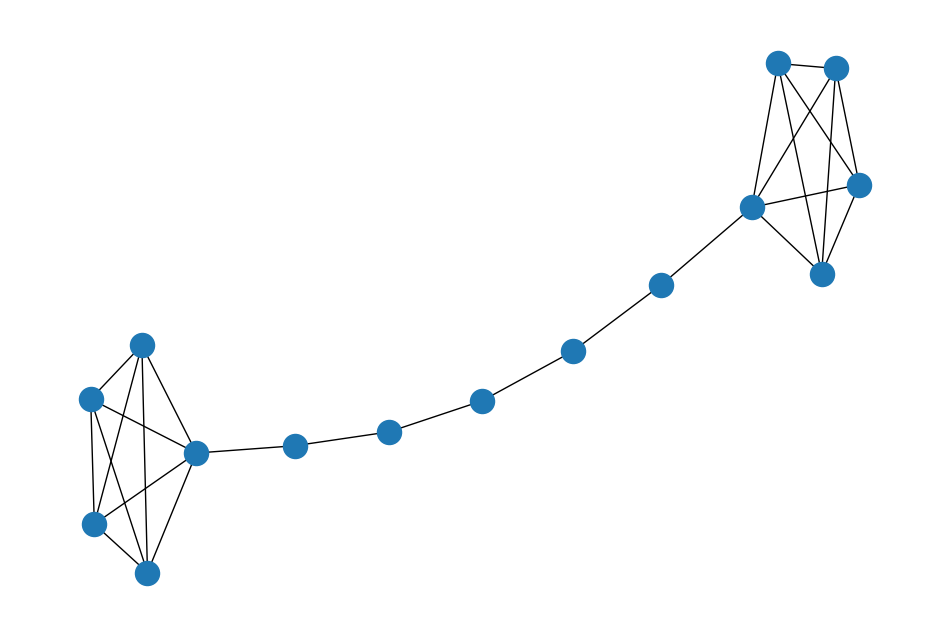

In [ ]:
fig,ax = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

plt.xlabel(r"$\mu$", fontsize = 36)
plt.ylabel(r"$p(\mu)$", fontsize = 36)

nx.draw(G, pos = node_pos, ax = ax)
plt.savefig("barbell-gtr-1.pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

In [ ]:
n = G.number_of_nodes()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D_orig = torch.zeros(n,n, dtype = torch.double)
for i in range(n):
  for j in range(n):
    D_orig[i,j] = d[i][j]

In [ ]:
D_orig

tensor([[0., 1., 1., 1., 1., 2., 3., 4., 5., 6., 7., 8., 8., 8., 8.],
        [1., 0., 1., 1., 1., 2., 3., 4., 5., 6., 7., 8., 8., 8., 8.],
        [1., 1., 0., 1., 1., 2., 3., 4., 5., 6., 7., 8., 8., 8., 8.],
        [1., 1., 1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 8., 8., 8.],
        [1., 1., 1., 1., 0., 1., 2., 3., 4., 5., 6., 7., 7., 7., 7.],
        [2., 2., 2., 2., 1., 0., 1., 2., 3., 4., 5., 6., 6., 6., 6.],
        [3., 3., 3., 3., 2., 1., 0., 1., 2., 3., 4., 5., 5., 5., 5.],
        [4., 4., 4., 4., 3., 2., 1., 0., 1., 2., 3., 4., 4., 4., 4.],
        [5., 5., 5., 5., 4., 3., 2., 1., 0., 1., 2., 3., 3., 3., 3.],
        [6., 6., 6., 6., 5., 4., 3., 2., 1., 0., 1., 2., 2., 2., 2.],
        [7., 7., 7., 7., 6., 5., 4., 3., 2., 1., 0., 1., 1., 1., 1.],
        [8., 8., 8., 8., 7., 6., 5., 4., 3., 2., 1., 0., 1., 1., 1.],
        [8., 8., 8., 8., 7., 6., 5., 4., 3., 2., 1., 1., 0., 1., 1.],
        [8., 8., 8., 8., 7., 6., 5., 4., 3., 2., 1., 1., 1., 0., 1.],
        [8., 8., 8.,

In [ ]:
VR = compute_homologies([D_orig], 3, sparse = False)

In [ ]:
VR

array([[[0., 0., 1.],
        [0., 0., 2.],
        [0., 0., 3.]]])

In [ ]:
from gtda.plotting import plot_diagram

i = 0
plot_diagram(VR[i])

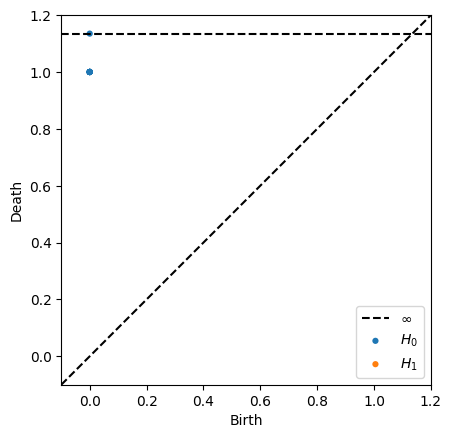

In [ ]:
n = G.number_of_nodes()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G)
D_orig = torch.zeros(n,n, dtype = torch.double)
for i in range(n):
  for j in range(n):
    D_orig[i,j] = d[i][j]

diagrams_orig = ripser(D_orig.numpy(), distance_matrix = True)['dgms']
plot_diagrams(diagrams_orig, show=True)

In [ ]:
ripser(D.numpy(), distance_matrix = True)['cocycles']

In [ ]:
LG = nx.normalized_laplacian_matrix(G)
eLG, evecsLG = find_eigen(LG.todense())
gapLG = eLG[1]
print(gapLG)

In [ ]:
plt.hist(commute_times(G).flatten())

In [ ]:
C,_ = curvature(G)
plt.hist(C)
print(C.mean())

In [ ]:
import copy
A, edge_to_index, L, D = create_views(G)

In [ ]:
for i in range(15):
  print(A[:,i].sum())

In [ ]:
L

In [ ]:
D

In [ ]:
k = 17
G1 = rewire_hhs(copy.deepcopy(G),1,A,edge_to_index,L,D,True)
G2 = rewire_hhs(copy.deepcopy(G),2,A,edge_to_index,L,D,True)
G3 = rewire_hhs(copy.deepcopy(G),3,A,edge_to_index,L,D,True)
G4 = rewire_hhs(copy.deepcopy(G),4,A,edge_to_index,L,D,True)
G5 = rewire_hhs(copy.deepcopy(G),5,A,edge_to_index,L,D,True)
G6 = rewire_hhs(copy.deepcopy(G),6,A,edge_to_index,L,D,True)
G7 = rewire_hhs(copy.deepcopy(G),7,A,edge_to_index,L,D,True)
G8 = rewire_hhs(copy.deepcopy(G),8,A,edge_to_index,L,D,True)
G9 = rewire_hhs(copy.deepcopy(G),9,A,edge_to_index,L,D,True)

In [ ]:
Ds = graphs_to_dists([G1,G2,G3,G4,G5,G6,G7,G8,G9])
dgms = compute_homologies(Ds, 1, sparse = False)

In [ ]:
dgms[8]

array([[1., 2., 1.]])

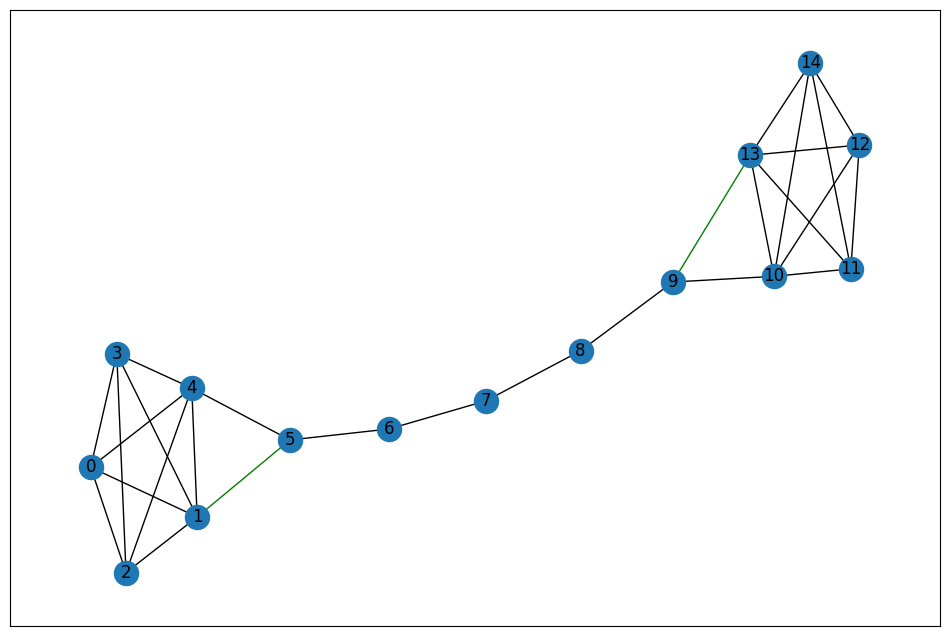

In [ ]:
k = 3
colors = []
edges_orig = list(G.edges())
edges = list(Ghats[k-1].edges())
for i in range(len(Ghats[k-1].edges())):
  if edges[i] not in edges_orig:
    colors.append("green")
  else:
    colors.append("black")
fig,ax = plt.subplots(figsize =(12, 8))

plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

nx.draw_networkx_nodes(Ghats[k-1], pos = pygraphviz_layout(Ghats[k-1]), ax = ax)
nx.draw_networkx_labels(Ghats[k-1], pos = pygraphviz_layout(Ghats[k-1]), ax = ax)
nx.draw_networkx_edges(Ghats[k-1], pos = pygraphviz_layout(Ghats[k-1]), ax = ax, edge_color = colors)
plt.savefig("barbell-sdrf-"+str(k)+".pdf", bbox_inches='tight', facecolor='white', dpi = 300, format = 'pdf')

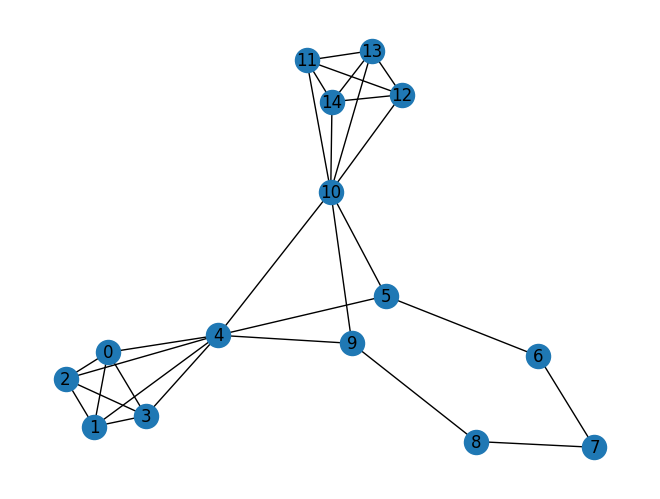

In [ ]:
nx.draw(G2, with_labels=True)

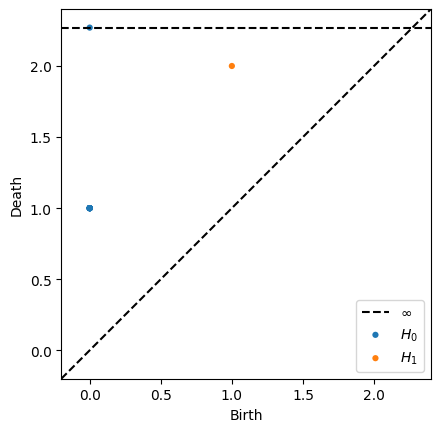

In [ ]:
n = G2.number_of_nodes()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(G2)
D = torch.zeros(n,n, dtype = torch.double)
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]

diagrams2 = ripser(D.numpy(), distance_matrix = True)['dgms']
plot_diagrams(diagrams2, show=True)

In [ ]:
distance_bottleneck, matching = persim.bottleneck(diagrams_orig[1], diagrams2[1], matching=True)
persim.bottleneck_matching(diagrams_orig[1], diagrams2[1], matching, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.show()
print(distance_bottleneck)

In [ ]:
LG2 = nx.normalized_laplacian_matrix(G2)
eLG2, evecsLG2 = find_eigen(LG2.todense())
gapLG2 = eLG2[1]
print(gapLG2)

In [ ]:
plt.hist(commute_times(G2).flatten())
print(commute_times(G2).flatten().mean())

In [ ]:
A = torch.tensor(nx.adjacency_matrix(G2).toarray(), dtype = torch.float).fill_diagonal_(0).cuda()
Curv = balanced_forman_curvature(A)
idx1, idx2 = torch.nonzero(A, as_tuple=True)
curv_flat = Curv[idx1,idx2].cpu()
plt.hist(curv_flat)
print(curv_flat.mean())

In [ ]:
Ghats = [None, None, None, None, None, None, None, None, None]
for i in range(9):
  Ghats[i] = sdrf(copy.deepcopy(G), loops=i+1, remove_edges = False)
# nx.draw(Ghat, with_labels=True)

<ipython-input-8-530b72784092>:210: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
Ghats

In [ ]:
Dhats_sdrf = graphs_to_dists(Ghats)
dgmhats_sdrf = compute_homologies(Dhats_sdrf, 1, sparse = False)

In [ ]:
for i in range(9):
  print(dgmhats_sdrf[i])
  print()

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 2. 1.]
 [1. 2. 1.]
 [1. 1. 1.]]

[[1. 2. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 2. 1.]
 [1. 2. 1.]
 [1. 2. 1.]]

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]



In [ ]:
n = Ghat.number_of_nodes()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(Ghat)
D = torch.zeros(n,n, dtype = torch.double)
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]

diagrams_ghat = ripser(D.numpy(), distance_matrix = True)['dgms']
plot_diagrams(diagrams_ghat, show=True)

In [ ]:
distance_bottleneck, matching = persim.bottleneck(diagrams_orig[1], diagrams_ghat[1], matching=True)
persim.bottleneck_matching(diagrams_orig[1], diagrams_ghat[1], matching, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.show()
print(distance_bottleneck)

In [ ]:
plt.hist(commute_times(Ghat).flatten())

In [ ]:
Chat,_ = curvature(Ghat)
plt.hist(Chat)
print(Chat.mean())

In [ ]:
LGhat = nx.normalized_laplacian_matrix(Ghat)
eLGhat, evecsLGhat = find_eigen(LGhat.todense())
gapLGhat = eLGhat[1]
print(gapLGhat)

In [ ]:
Ghat1 = fosr(copy.deepcopy(G),r=50, k=1)
Ghat2 = fosr(copy.deepcopy(G),r=50, k=2)
Ghat3 = fosr(copy.deepcopy(G),r=50, k=3)
Ghat4 = fosr(copy.deepcopy(G),r=50, k=4)
Ghat5 = fosr(copy.deepcopy(G),r=50, k=5)
Ghat6 = fosr(copy.deepcopy(G),r=50, k=6)
Ghat7 = fosr(copy.deepcopy(G),r=50, k=7)
Ghat8 = fosr(copy.deepcopy(G),r=50, k=8)
Ghat9 = fosr(copy.deepcopy(G),r=50, k=9)
# nx.draw(Ghat, with_labels=True)

<ipython-input-9-e4479a76f383>:102: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float)
<ipython-input-9-e4479a76f383>:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = torch.tensor(nx.adjacency_matrix(G).toarray()).to(torch.float)


In [ ]:
Dhats = graphs_to_dists([Ghat1,Ghat2,Ghat3,Ghat4,Ghat5,Ghat6,Ghat7,Ghat8,Ghat9])
dgmhats = compute_homologies(Dhats, 1, sparse = False)

In [ ]:
dgmhats[8]

array([[1., 2., 1.],
       [1., 2., 1.],
       [1., 2., 1.],
       [1., 2., 1.],
       [1., 2., 1.],
       [1., 2., 1.],
       [1., 1., 1.]])

In [ ]:
Ds = graphs_to_dists([G,G2,Ghat])
dgms = compute_homologies(Ds, 3, sparse = False)
dists = homology_distance(dgms, metric = "betti")

In [ ]:
Ds[1]

tensor([[0., 1., 1., 1., 1., 2., 3., 4., 4., 3., 2., 3., 3., 3., 3.],
        [1., 0., 1., 1., 1., 2., 3., 4., 4., 3., 2., 3., 3., 3., 3.],
        [1., 1., 0., 1., 1., 2., 3., 4., 4., 3., 2., 3., 3., 3., 3.],
        [1., 1., 1., 0., 1., 2., 3., 4., 4., 3., 2., 3., 3., 3., 3.],
        [1., 1., 1., 1., 0., 1., 2., 3., 3., 2., 1., 2., 2., 2., 2.],
        [2., 2., 2., 2., 1., 0., 1., 2., 3., 3., 2., 3., 3., 3., 3.],
        [3., 3., 3., 3., 2., 1., 0., 1., 2., 3., 3., 4., 4., 4., 4.],
        [4., 4., 4., 4., 3., 2., 1., 0., 1., 2., 3., 4., 4., 4., 4.],
        [4., 4., 4., 4., 3., 3., 2., 1., 0., 1., 2., 3., 3., 3., 3.],
        [3., 3., 3., 3., 2., 3., 3., 2., 1., 0., 1., 2., 2., 2., 2.],
        [2., 2., 2., 2., 1., 2., 3., 3., 2., 1., 0., 1., 1., 1., 1.],
        [3., 3., 3., 3., 2., 3., 4., 4., 3., 2., 1., 0., 1., 1., 1.],
        [3., 3., 3., 3., 2., 3., 4., 4., 3., 2., 1., 1., 0., 1., 1.],
        [3., 3., 3., 3., 2., 3., 4., 4., 3., 2., 1., 1., 1., 0., 1.],
        [3., 3., 3.,

In [ ]:
dists

array([[0.        , 1.41421356, 2.44948974],
       [1.41421356, 0.        , 2.        ],
       [2.44948974, 2.        , 0.        ]])

In [ ]:
print(dgms[0])
plot_diagram(dgms[0])

[[1. 1. 1.]
 [3. 3. 2.]
 [3. 3. 2.]
 [0. 0. 3.]]


In [ ]:
print(dgms[1])
plot_diagram(dgms[1])

[[1. 3. 1.]
 [3. 3. 2.]
 [3. 3. 2.]
 [0. 0. 3.]]


In [ ]:
plot_diagram(dgms[2])

In [ ]:
n = Ghat.number_of_nodes()
d = nx.algorithms.shortest_paths.dense.floyd_warshall(Ghat)
D = torch.zeros(n,n, dtype = torch.double)
for i in range(n):
  for j in range(n):
    D[i,j] = d[i][j]

diagrams_ghat = ripser(D.numpy(), distance_matrix = True)['dgms']
plot_diagrams(diagrams_ghat, show=True)

In [ ]:
distance_bottleneck, matching = persim.bottleneck(diagrams_orig[1], diagrams_ghat[1], matching=True)
persim.bottleneck_matching(diagrams_orig[1], diagrams_ghat[1], matching, labels=['Clean $H_1$', 'Noisy $H_1$'])
plt.show()
print(distance_bottleneck)

In [ ]:
plt.hist(commute_times(Ghat).flatten())
print(commute_times(Ghat).flatten().mean())

In [ ]:
Chat,_ = curvature(Ghat)
plt.hist(Chat)
print(Chat.mean())

In [ ]:
LGhat = nx.normalized_laplacian_matrix(Ghat)
eLGhat, evecsLGhat = find_eigen(LGhat.todense())
gapLGhat = eLGhat[1]
print(gapLGhat)

In [ ]:
import copy

edges = 500

avg_commute = torch.zeros(3,edges)
avg_curv = torch.zeros(3,edges)
eigen_gap = torch.zeros(3,edges)
bottleneck_distance = torch.zeros(3,edges)

# A, edge_to_index, L, D = create_views(G)

for idx1 in tqdm(range(edges)):
  for idx2 in range(1):
    if idx2 == 0:
      G2 = rewire(copy.deepcopy(G),idx1+1,A,edge_to_index,L,D,True)
    if idx2 == 1:
      G2 = sdrf(copy.deepcopy(G),loops=idx1+1)
    if idx2 == 2:
      G2 = fosr(copy.deepcopy(G),r=50, k=idx1+1)

    n = G2.number_of_nodes()
    d = nx.algorithms.shortest_paths.dense.floyd_warshall(G2)
    D2 = torch.zeros(n,n, dtype = torch.double)
    for i in range(n):
      for j in range(n):
        D2[i,j] = d[i][j]

    diagrams2 = ripser(D2.numpy(), distance_matrix = True)['dgms']
    distance_bottleneck, matching = persim.bottleneck(diagrams_orig[1], diagrams2[1], matching=True)
    bottleneck_distance[idx2,idx1] = distance_bottleneck

    LG2 = nx.normalized_laplacian_matrix(G2)
    eLG2, evecsLG2 = find_eigen(LG2.todense())
    gapLG2 = eLG2[1]
    eigen_gap[idx2,idx1] = gapLG2

    # A2 = torch.tensor(nx.adjacency_matrix(G2).toarray(), dtype = torch.float).fill_diagonal_(0).cuda()
    # Curv2 = balanced_forman_curvature(A2)
    # idx1_c, idx2_c = torch.nonzero(A2, as_tuple=True)
    # curv_flat = Curv[idx1_c,idx2_c].cpu()
    # avg_curv[idx2,idx1] = curv_flat.mean()

    avg_commute[idx2,idx1] = commute_times(G2).flatten().mean()

In [ ]:
plt.plot(bottleneck_distance[0,:], label = "HHS")
plt.plot(bottleneck_distance[1,:], label = "SDRF")
plt.plot(bottleneck_distance[2,:], label = "FoSR")
plt.legend()

In [ ]:
plt.plot(eigen_gap[0,:], label = "HHS")
# plt.plot(eigen_gap[1,:], label = "SDRF")
plt.plot(eigen_gap[2,:], label = "FoSR")
plt.legend()

In [ ]:
plt.plot(avg_commute[0,:], label = "HHS")
# plt.plot(avg_commute[1,:], label = "SDRF")
plt.plot(avg_commute[2,:], label = "FoSR")
plt.legend()

In [ ]:
# dataset = torch_geometric.datasets.TUDataset(root='data/', name = "PROTEINS", use_node_attr=True)
dataset = torch_geometric.datasets.WebKB(root="data/", name = "Cornell")

In [ ]:
# dataset[0]
# with open("pubmed.pkl", "wb") as f:
#   pickle.dump(dataset[0].edge_index.numpy(), f, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
from torch_geometric.utils import to_dense_adj
adj_matrix = to_dense_adj(dataset.edge_index)[0]

In [ ]:
(adj_matrix - adj_matrix.T).abs().sum()
n = adj_matrix.shape[0]
for i in range(n):
  for j in range(n):
    adj_matrix[i,j] = torch.max(adj_matrix[i,j],adj_matrix[j,i])
(adj_matrix - adj_matrix.T).abs().sum()

In [ ]:
G = nx.from_numpy_matrix(adj_matrix.numpy())

In [ ]:
path = "./drive/MyDrive/CubeRep/GNN/Data/Graph Classification/"

In [ ]:
with open(path + "actor-aug.pkl", 'rb') as handle:
    data_aug = pickle.load(handle)

In [ ]:
data = dataset[0]

In [ ]:
dataset = [data]

In [ ]:
def adj_to_edge_index(adj):
  n = adj.shape[0]
  edge_index = torch.zeros(2,0, dtype = torch.long)
  for i in tqdm(range(n)):
    for j in range(n):
      if adj[i,j] > 0.1:
        edge = torch.tensor([i, j]).view(2,1)
        edge_index = torch.cat((edge_index, edge), dim = 1)
  return edge_index

In [ ]:
from torch.utils.data.distributed import Dataset

def augment_dataset(dataset, data_aug, embeddings = None):
  N = len(data_aug)
  dataset_new = []
  for i in tqdm(range(N)):
    data = dataset[i]
    data.edge_edge_index = torch.tensor(data_aug[str(i+1)][0]).nonzero().t().contiguous().to(torch.long) #adj_to_edge_index(data_aug[str(i+1)][0])
    if embeddings != None:
      data.edge_attr = torch.cat((embeddings[i], embeddings[i]), dim = 0)
    # data.edge_to_edgeidx = data_aug[str(i+1)][1]
    dataset_new.append(data)
  return dataset_new

# This gives the ordering from edges in edge_index
# to their index.
#
# We use this in resort_edge_index to correctly
# sort the edge_attr tensor.
def calc_edge_to_edge_index_idx(edge_index):
  N = edge_index.shape[1]
  edge_to_edge_index_idx = dict()
  for i in range(N):
    edge_to_edge_index_idx[(edge_index[0,i].item(), edge_index[1,i].item())] = i
    edge_to_edge_index_idx[(edge_index[1,i].item(), edge_index[0,i].item())] = i
  return edge_to_edge_index_idx

# The idea here is that we want the edge_attr vector
# to be the same sorting as edge_index.
# However, what we have is that edge_attr comes from
# x_edge. So we take the edge_to_edgeidx sorting
# and re-sort edge_index using that ordering.
# Then once we have x_edge, we can concatenate it
# to itself to get edge_attr.
# so if we have edges (0,1), (0,2), (0,3), (1,2)
# edge_index will be sorted as (0,1), (0,2), (0,3)
# (1,2), (1,0), (2,0), (3,0), (2,1)
#
# We need edge_to_edge_index_idx to correctly sort
# the edge_attr tensor.
def resort_edge_index(dataset, data_aug, embeddings = None):
  N = len(data_aug)
  print(N)
  for i in tqdm(range(N)):
    edge_to_edgeidx = data_aug[str(i+1)][1]
    keys = edge_to_edgeidx.keys()
    n = len(keys)
    if embeddings != None:
      edge_attr = torch.clone(dataset[i].edge_attr)
    edge_to_edge_index_idx = calc_edge_to_edge_index_idx(dataset[i].edge_index)
    edge_index = torch.zeros(2,2*n, dtype = dataset[i].edge_index.dtype)
    for k in keys:
      v = edge_to_edgeidx[k]
      edge_index[0,v] = k[0]
      edge_index[1,v] = k[1]
      edge_index[0,v+n] = k[1]
      edge_index[1,v+n] = k[0]
      # dataset[i].edge_index[0,v] = k[0]
      # dataset[i].edge_index[1,v] = k[1]
      # dataset[i].edge_index[0,v+n] = k[1]
      # dataset[i].edge_index[1,v+n] = k[0]

      if embeddings != None:
        dataset[i].edge_attr[v,:] = edge_attr[edge_to_edge_index_idx[k], :]
        dataset[i].edge_attr[v+n,:] = edge_attr[edge_to_edge_index_idx[k], :]
        # dataset[i].edge_attr[v+n,:] = edge_attr[edge_to_edge_index_idx[(k[1], k[0])], :] # This is for the reverse edge
    dataset[i].edge_index = edge_index
  return dataset


class AugDataset(InMemoryDataset):
  def __init__(self, dataset, data_aug, embeddings = None):
    super(AugDataset, self).__init__('.', None, None, None)

    dataset = augment_dataset(dataset, data_aug, embeddings)
    self.dataset_new = resort_edge_index(dataset, data_aug, embeddings)


  def get(self, idx):
    return self.dataset_new[idx]

  def len(self):
    return len(self.dataset_new)

  def _download(self):
    return

  def _process(self):
      return

  def __repr__(self):
      return '{}()'.format(self.__class__.__name__)

class HHSLayer(torch.nn.Module):
  '''
  Inputs:
    First for the Node GNN
    node_input_dim = dimension of node features into node GNN layer
    node_output_dim = dimension of node features after node GNN layer
    edge_dim = dimension of edge attr for the first node GNN layer

    Second for to make inputs for Edge GNN
    edge_attr_dim = dimension of edge_attr from the previous layer (it would be the previous edge_output_dim)

    Thirs for the Edge GNN
    edge_input_dim = dimension for the edge features for the Edge GNN
    edge_output_dim = dimension for the output from the Edge GNN

  '''
  def __init__(self, node_input_dim, node_output_dim, edge_dim, edge_attr_dim, edge_input_dim, edge_output_dim, edge_attr = True):
    super().__init__()

    # For mapping edge_attr to edge_input
    self.mlp1 = torch.nn.Sequential(torch.nn.Linear(edge_attr_dim, edge_input_dim),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(edge_input_dim, edge_input_dim))

    # For mapping node_output to edge_input
    self.mlp2 = torch.nn.Sequential(torch.nn.Linear(node_output_dim, edge_input_dim),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(edge_input_dim, edge_input_dim))

    self.edge_attr = edge_attr
    if self.edge_attr:
      self.node_layer = torch_geometric.nn.TransformerConv(node_input_dim, node_output_dim, edge_dim = edge_attr_dim)
    else:
      self.node_layer = torch_geometric.nn.TransformerConv(node_input_dim, node_output_dim)
    self.edge_layer = torch_geometric.nn.TransformerConv(edge_input_dim, edge_output_dim)

  def forward(self, x, edge_index, edge_attr, edge_edge_index):
    # Process the node features to edge_input
    if self.edge_attr:
      node_out = self.node_layer(x, edge_index, edge_attr = edge_attr).relu()
    else:
      node_out = self.node_layer(x,edge_index)
    edge_node_input = self.mlp2(node_out)

    # Process the edge atrr to edge_input
    if self.edge_attr:
      edge_attr_input = self.mlp1(edge_attr)

    # Add these two together
    if self.edge_attr:
      edge_input = edge_attr_input + edge_node_input[edge_index[0,:],:] + edge_node_input[edge_index[1,:],:]
    else:
      edge_input = edge_node_input[edge_index[0,:],:] + edge_node_input[edge_index[1,:],:]


    # Hopefully the above does the following loop
    # for i in range(N):
    #   u = edge_index[0,i]
    #   v = edge_index[1,i]
    #   edge_attr_input[i,:] = edge_attr_input + edge_node_input[u,:] + edge_node_input[v,:]

    N = edge_input.shape[0]

    edge_output = self.edge_layer(edge_input[:N//2,:], edge_edge_index)

    edge_output = torch.cat((edge_output, edge_output), dim = 0)

    return node_out, edge_output

class HHSConv(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, edge_input_dim, hidden_dim = 128, layer_1_attr = True):
    super().__init__()

    self.layer1 = HHSLayer(node_input_dim, hidden_dim, hidden_dim, edge_input_dim, hidden_dim, hidden_dim, edge_attr = layer_1_attr)
    self.layer2 = HHSLayer(hidden_dim, hidden_dim, hidden_dim, hidden_dim, hidden_dim, hidden_dim)

    self.lin = torch.nn.Linear(hidden_dim, num_classes)

  def forward(self, x, edge_index, edge_attr, edge_edge_index, batch):
    x_1, edge_attr_1 = self.layer1(x, edge_index, edge_attr, edge_edge_index)
    x_2, edge_attr_2 = self.layer2(x_1, edge_index, edge_attr_1, edge_edge_index)
    x_3 = torch_geometric.nn.global_mean_pool(x_2, batch)
    z = self.lin(x_3)
    return z

class TransformerGraphConv(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, edge_input_dim, hidden_dim = 128):
    super().__init__()

    self.layer1 = torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim)
    self.layer2 = torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim)

    self.lin = torch.nn.Linear(hidden_dim, num_classes)

  def forward(self, x, edge_index, edge_attr, edge_edge_index, batch):
    x_1 = self.layer1(x, edge_index).relu()
    x_2 = self.layer2(x_1, edge_index).relu()
    x_3 = torch_geometric.nn.global_mean_pool(x_2, batch)
    z = self.lin(x_3)
    return z

class WeightedTransformerConv(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, edge_input_dim, hidden_dim = 128):
    super().__init__()

    self.layer1 = torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim, edge_dim = edge_input_dim)
    self.layer2 = torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim, edge_dim = edge_input_dim)

    self.lin = torch.nn.Linear(hidden_dim, num_classes)

  def forward(self, x, edge_index, edge_attr, edge_edge_index, batch):
    x_1 = self.layer1(x, edge_index, edge_attr = edge_attr).relu()
    x_2 = self.layer2(x_1, edge_index, edge_attr = edge_attr).relu()
    x_3 = torch_geometric.nn.global_mean_pool(x_2, batch)
    z = self.lin(x_3)
    return z

class HHSConvNode(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, edge_input_dim, hidden_dim = 128, layer_1_attr = True):
    super().__init__()

    self.layer1 = HHSLayer(node_input_dim, hidden_dim, hidden_dim, edge_input_dim, hidden_dim, hidden_dim, edge_attr = layer_1_attr)
    self.layer2 = HHSLayer(hidden_dim, hidden_dim, hidden_dim, hidden_dim, hidden_dim, hidden_dim)
    self.layer3 = HHSLayer(hidden_dim, hidden_dim, hidden_dim, hidden_dim, hidden_dim, hidden_dim)

    self.lin = torch.nn.Linear(hidden_dim, num_classes)

  def forward(self, x, edge_index, edge_attr, edge_edge_index, batch):
    x_1, edge_attr_1 = self.layer1(x, edge_index, edge_attr, edge_edge_index)
    x_2, edge_attr_2 = self.layer2(x_1, edge_index, edge_attr_1, edge_edge_index)
    x_3, edge_attr_3 = self.layer2(x_2, edge_index, edge_attr_2, edge_edge_index)

    z = self.lin(x_3)
    return z

class TransformerGraphConvNode(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, edge_input_dim, hidden_dim = 128):
    super().__init__()

    self.layer1 = torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim)
    self.layer2 = torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim)

    self.lin = torch.nn.Linear(hidden_dim, num_classes)

  def forward(self, x, edge_index, edge_attr, edge_edge_index, batch):
    x_1 = self.layer1(x, edge_index).relu()
    x_2 = self.layer2(x_1, edge_index).relu()

    z = self.lin(x_2)
    return z

class WeightedTransformerConvNode(torch.nn.Module):
  def __init__(self, node_input_dim, num_classes, edge_input_dim, hidden_dim = 128):
    super().__init__()

    self.layer1 = torch_geometric.nn.TransformerConv(node_input_dim, hidden_dim, edge_dim = edge_input_dim)
    self.layer2 = torch_geometric.nn.TransformerConv(hidden_dim, hidden_dim, edge_dim = edge_input_dim)

    self.lin = torch.nn.Linear(hidden_dim, num_classes)

  def forward(self, x, edge_index, edge_attr, edge_edge_index, batch):
    x_1 = self.layer1(x, edge_index, edge_attr = edge_attr).relu()
    x_2 = self.layer2(x_1, edge_index, edge_attr = edge_attr).relu()

    z = self.lin(x_2)
    return z

from torch_geometric.data import InMemoryDataset
import torch_geometric.data as geom_data

class EdgeDataset(InMemoryDataset):
    def __init__(self,  edge_edge_index, n, transform=None):
        super(EdgeDataset, self).__init__('.', transform, None, None)

        data = geom_data.Data(edge_index = edge_edge_index)

        data.num_nodes = n

        # embedding
        # data.x = emb_edge.clone().detach()

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [ ]:
# dataset_aug = AugDataset(dataset, data_aug, None)

In [ ]:
# torch.save(dataset_aug, path+"actor-dataset.pt")

dataset_aug = torch.load(path+"actor-dataset.pt")

In [ ]:
data_edge = EdgeDataset(dataset_aug[0].edge_edge_index, 26752)[0]

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
from torch_geometric.loader import GraphSAINTRandomWalkSampler

train_loader = DataLoader(dataset_aug, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset_aug, batch_size=1, shuffle=False)


# model = HHSConvNode(1703,5,128, hidden_dim = 128)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay = 0.01)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
# criterion = torch.nn.CrossEntropyLoss()

path = "./drive/MyDrive/CubeRep/GNN/Data/Graph Classification/Actor/"

def train(model, train_loader, edge_loader = None):
  model.train()

  if edge_loader != None:
    for data in train_loader:
      for data_edge in edge_loader:  # Iterate in batches over the training dataset.
        data = data.to('cuda')
        data_edge = data_edge.to('cuda')
        out = model(data.x, data.edge_index, data.edge_attr, data_edge.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask[:,idx]], data.y[data.train_mask[:,idx]])  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        scheduler.step()
        optimizer.zero_grad()  # Clear gradients.
  else:
    for data in train_loader:
      data = data.to('cuda')
      out = model(data.x, data.edge_index, data.edge_attr, data.edge_edge_index, data.batch)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask[:,idx]], data.y[data.train_mask[:,idx]])  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      scheduler.step()
      optimizer.zero_grad()  # Clear gradients.

  return model

def test(loader, mask, edge_loader = None):
  model.eval()

  correct = 0
  if edge_loader != None:
    for data in loader:
      T = 0
      for data_edge in edge_loader: # Iterate in batches over the training/test dataset.
        T += 1
        data = data.to('cuda')
        data_edge = data_edge.to('cuda')
        out = model(data.x, data.edge_index, data.edge_attr, data_edge.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred[mask] == data.y[mask]).sum())  # Check against ground-truth labels.
      correct /= T
    return correct / data.y[mask].shape[0]  # Derive ratio of correct predictions.
  else:
    for data in loader:
      data = data.to('cuda')
      out = model(data.x, data.edge_index, data.edge_attr, data.edge_edge_index, data.batch)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct += int((pred[mask] == data.y[mask]).sum())  # Check against ground-truth labels.
    return correct / data.y[mask].shape[0]  # Derive ratio of correct predictions.


# edge_loader = GraphSAINTRandomWalkSampler(data_edge, batch_size=128, walk_length = 5, num_workers=4, num_steps = 10)
# torch.save(edge_loader, path+"edge_loader.pt")

edge_loader = torch.load(path+"edge_loader.pt")

for iter in range(5):
  for idx in range(10):

    epochs = 100

    # model = HHSConvNode(1703,5,128, hidden_dim = 128).to('cuda')
    # optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    # criterion = torch.nn.CrossEntropyLoss()

    # max_val = 0

    # for epoch in tqdm(range(1, epochs+1)):
    #     model = train(model, train_loader)
    #     train_acc = test(train_loader, data.train_mask[:,idx])
    #     test_acc = test(test_loader, data.test_mask[:,idx])
    #     val_acc = test(test_loader, data.val_mask[:,idx])
    #     if val_acc > max_val:
    #       max_val = val_acc
    #       print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    #       torch.save(model, path+"texas-hhs-2layer-idx-"+str(idx)+"-"+str(iter)+".pt")


    model = HHSConvNode(932,5,32,  hidden_dim = 32, layer_1_attr=False).to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.CrossEntropyLoss()

    max_val = 0

    for epoch in tqdm(range(1, epochs+1)):
        model = train(model, train_loader,edge_loader)
        train_acc = test(train_loader, data.train_mask[:,idx],edge_loader)
        test_acc = test(test_loader, data.test_mask[:,idx],edge_loader)
        val_acc = test(test_loader, data.val_mask[:,idx],edge_loader)
        if val_acc > max_val or epoch > 20:
          max_val = val_acc
          print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
          torch.save(model, path+"actor-hhs-3layer-edge-attr-false-idx-"+str(idx)+"-"+str(iter)+".pt")

    epochs = 500

    model = TransformerGraphConvNode(932,5,128, hidden_dim = 128).to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    criterion = torch.nn.CrossEntropyLoss()

    max_val = 0

    for epoch in tqdm(range(1, epochs+1)):
        model = train(model, train_loader)
        train_acc = test(train_loader, data.train_mask[:,idx])
        test_acc = test(test_loader, data.test_mask[:,idx])
        val_acc = test(test_loader, data.val_mask[:,idx])
        if val_acc > max_val:
          max_val = val_acc
          print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
          torch.save(model, path+"actor-transformer-2layer-idx-"+str(idx)+"-"+str(iter)+".pt")

    # model = WeightedTransformerConvNode(1703,5,128, hidden_dim = 128).to('cuda')
    # optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    # criterion = torch.nn.CrossEntropyLoss()

    # max_val = 0

    # for epoch in tqdm(range(1, epochs+1)):
    #     model = train(model, train_loader)
    #     train_acc = test(train_loader, data.train_mask[:,idx])
    #     test_acc = test(test_loader, data.test_mask[:,idx])
    #     val_acc = test(test_loader, data.val_mask[:,idx])
    #     if val_acc > max_val:
    #       max_val = val_acc
    #       print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    #       torch.save(model, path+"texas-weighted-transformer-2layer-idx-"+str(idx)+"-"+str(iter)+".pt")

# for epoch in range(1, 1000):
#     train()
#     train_acc = test(train_loader, data.train_mask[:,idx])
#     test_acc = test(test_loader, data.test_mask[:,idx])
#     val_acc = test(test_loader, data.val_mask[:,idx])
#     print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')